# COGS 108 - EDA Checkpoint

# Names

- Sarah Borsotto
- Niharika Malhotra
- Marvin Ochoa Estrada
- Ann Luong
- Dhathry Doppalapudi

<a id='research_question'></a>
# Research Question

Is there a correlation between the amount of parking tickets issued in different regions of Los Angeles country and the ami category of those regions?

# Setup

In [1]:
%pip install geopandas
%pip install shapely
%pip install pyshp

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
sns.set(font_scale=2, style="white")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
plt.rcParams['figure.figsize'] = (12, 5)

#Plots latitude and longitude points on a map
from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame

#Converts state plane coordinates to latitude and longitude
from pyproj import Proj, transform

import shapefile as shp
import plotly.graph_objects as go
%config InlineBackend.figure_format = 'retina'

# Data Cleaning

First, we will read the parking ticket dataset and find out what information we can extract from it. 

Since, the parking citation dataset is too large to store on GitHub, we will only be showing our data cleaning process on a subset of this data. Our exploratory data analysis will still use the cleaned data from the original dataset, however.

In [3]:
citations = pd.read_csv(r"Parking_Citations_Subset.csv")

/tmp/ipykernel_365/2307732268.py:1: DtypeWarning: Columns (0,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  citations = pd.read_csv(r"Parking_Citations_Subset.csv")


In [4]:
print(citations.columns)
print(citations.shape)
citations.head()

Index(['Ticket number', 'Issue Date', 'Issue time', 'Meter Id', 'Marked Time',
       'RP State Plate', 'Plate Expiry Date', 'VIN', 'Make', 'Body Style',
       'Color', 'Location', 'Route', 'Agency', 'Violation code',
       'Violation Description', 'Fine amount', 'Latitude', 'Longitude',
       'Agency Description', 'Color Description', 'Body Style Description'],
      dtype='object')
(80000, 22)


,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description
0,4266161336,09/09/2015,834.0,NaN,NaN,CA,201603.0,NaN,CHEV,PA,...,00153,51.0,22502A,18 IN. CURB/2 WAY,63.0,6430758.0,1840524.3,NaN,NaN,NaN
1,4271414125,11/12/2015,1929.0,BF759,NaN,CA,201512.0,NaN,HOND,PA,...,00474,54.0,88.13B+,METER EXP.,63.0,6452215.3,1851762.0,NaN,NaN,NaN
2,4253402904,02/18/2015,1011.0,NaN,NaN,CA,201509.0,NaN,KIA,PA,...,00644,56.0,80.56E4+,RED ZONE,93.0,6480902.5,1846099.1,NaN,NaN,NaN
3,4258559896,05/06/2015,1109.0,NaN,NaN,CA,10.0,NaN,OTHR,CM,...,00688,56.0,80.56E2,YELLOW ZONE,58.0,99999.0,99999.0,NaN,NaN,NaN
4,4267414771,09/25/2015,1806.0,BH203,NaN,CA,201607.0,NaN,TOYT,PA,...,00642,56.0,88.13B+,METER EXP.,63.0,6498368.6,1839669.7,NaN,NaN,NaN


Next, we are going to get rid of all of teh columns that we don't need and then drop any rows that have missing values. The information that is of interest to us is:
- ticket number
- issue date
- State Plate
- Make
- Location
- Violation code
- Violation description
- Fine amount
- Latitude
- Longitude

In [5]:
citations = citations[['Ticket number', 'Issue Date', 'RP State Plate', 'Make', 'Location', 'Violation code', 'Violation Description', 'Fine amount', 'Latitude', 'Longitude']]
citations = citations.dropna()
print(citations.shape)
citations.head()

(77185, 10)


,Ticket number,Issue Date,RP State Plate,Make,Location,Violation code,Violation Description,Fine amount,Latitude,Longitude
0,4266161336,09/09/2015,CA,CHEV,1946 SELBY AVE,22502A,18 IN. CURB/2 WAY,63.0,6430758.0,1840524.3
1,4271414125,11/12/2015,CA,HOND,500 FAIRFAX AV N,88.13B+,METER EXP.,63.0,6452215.3,1851762.0
2,4253402904,02/18/2015,CA,KIA,107 SOUTH BURLINGTON AVENUE,80.56E4+,RED ZONE,93.0,6480902.5,1846099.1
3,4258559896,05/06/2015,CA,OTHR,860 SANTEE ST S,80.56E2,YELLOW ZONE,58.0,99999.0,99999.0
4,4267414771,09/25/2015,CA,TOYT,2300 CESAR E CHAVEZ AV E,88.13B+,METER EXP.,63.0,6498368.6,1839669.7


Now, we are going to extract the year that each ticket was issued to make it easier to filter the data

In [6]:
citations['year'] = pd.to_datetime(citations['Issue Date'], format='%m/%d/%Y').dt.year
citations.head()

,Ticket number,Issue Date,RP State Plate,Make,Location,Violation code,Violation Description,Fine amount,Latitude,Longitude,year
0,4266161336,09/09/2015,CA,CHEV,1946 SELBY AVE,22502A,18 IN. CURB/2 WAY,63.0,6430758.0,1840524.3,2015
1,4271414125,11/12/2015,CA,HOND,500 FAIRFAX AV N,88.13B+,METER EXP.,63.0,6452215.3,1851762.0,2015
2,4253402904,02/18/2015,CA,KIA,107 SOUTH BURLINGTON AVENUE,80.56E4+,RED ZONE,93.0,6480902.5,1846099.1,2015
3,4258559896,05/06/2015,CA,OTHR,860 SANTEE ST S,80.56E2,YELLOW ZONE,58.0,99999.0,99999.0,2015
4,4267414771,09/25/2015,CA,TOYT,2300 CESAR E CHAVEZ AV E,88.13B+,METER EXP.,63.0,6498368.6,1839669.7,2015


We're only interested in looking at data from the past 5 years, so we're only going to look at entries in which the issue year is between 2018 and 2022 (inclusive)

In [7]:
citations = citations[citations['year'].isin(range(2018,2023)) == True]
print(citations.shape)
citations['year'].value_counts()

(47254, 11)


2018    9982
2019    9788
2022    9293
2020    9290
2021    8901
Name: year, dtype: int64

In [8]:
citations.head()

,Ticket number,Issue Date,RP State Plate,Make,Location,Violation code,Violation Description,Fine amount,Latitude,Longitude,year
30000,4337010996,08/28/2018,CA,MERZ,800 SWEETZER AVE N,80.56E4+,RED ZONE,93.0,6.449564e+06,1.853668e+06,2018
30001,4341394805,10/11/2018,CA,NISS,4077 MISSION ROAD N,80.56E4+,RED ZONE,93.0,6.502592e+06,1.850105e+06,2018
30002,4328977435,03/26/2018,CA,TOYT,2201 BUTLER AV,88.13B+,METER EXP.,63.0,6.427126e+06,1.835964e+06,2018
30003,4338522016,08/20/2018,CA,TOYT,7356 HOLLYWOOD BLVD,80.69AP+,NO STOP/STANDING,93.0,6.455583e+06,1.859553e+06,2018
30004,4345254185,12/16/2018,CA,MITS,1201 INGRAHAM ST,5204A-,DISPLAY OF TABS,25.0,6.481294e+06,1.841501e+06,2018


Looking at `df.head`, you can see that there are a lot of invalid latitude and longitude coordinates (longitude and latitude are 99999). You can also see that the coordinates are represented with the California Zone 5 State Plane Coordinate System instead of the regular longitude and latitude coordinates that we are used to. We need the latitude and longitude coordinates to plot the location of the tickets on a map, so for now we are only going to look at entries with valid State Plane coordinates and convert them to the proper values

In [9]:
citations = citations[citations['Longitude'] != 99999]
print(citations.shape)
citations.head()

(43651, 11)


,Ticket number,Issue Date,RP State Plate,Make,Location,Violation code,Violation Description,Fine amount,Latitude,Longitude,year
30000,4337010996,08/28/2018,CA,MERZ,800 SWEETZER AVE N,80.56E4+,RED ZONE,93.0,6.449564e+06,1.853668e+06,2018
30001,4341394805,10/11/2018,CA,NISS,4077 MISSION ROAD N,80.56E4+,RED ZONE,93.0,6.502592e+06,1.850105e+06,2018
30002,4328977435,03/26/2018,CA,TOYT,2201 BUTLER AV,88.13B+,METER EXP.,63.0,6.427126e+06,1.835964e+06,2018
30003,4338522016,08/20/2018,CA,TOYT,7356 HOLLYWOOD BLVD,80.69AP+,NO STOP/STANDING,93.0,6.455583e+06,1.859553e+06,2018
30004,4345254185,12/16/2018,CA,MITS,1201 INGRAHAM ST,5204A-,DISPLAY OF TABS,25.0,6.481294e+06,1.841501e+06,2018


In our original dataset, there were over 7 million entries left at this point in our data cleaning. Doing the conversion for every entry would take multiple days for our computers to run so we're only going to look at 5000 entries from each year. However, for the sake of runtime, we will only be showing the rest of our data cleaning process on 1000 entries from each year.

In [10]:
citations2018 = citations[citations['year'] == 2018]
citations2018 = citations2018.sample(frac = 1) # shuffle the data
citations2018 = citations2018.head(1000)

In [11]:
citations2019 = citations[citations['year'] == 2019]
citations2019 = citations2019.sample(frac = 1)
citations2019 = citations2019.head(1000)

In [12]:
citations2020 = citations[citations['year'] == 2020]
citations2020 = citations2020.sample(frac = 1)
citations2020 = citations2020.head(1000)

In [13]:
citations2021 = citations[citations['year'] == 2021]
citations2021 = citations2021.sample(frac = 1)
citations2021 = citations2021.head(1000)

In [14]:
citations2022 = citations[citations['year'] == 2022]
citations2022 = citations2022.sample(frac = 1)
citations2022 = citations2022.head(1000)

In [15]:
citations = pd.concat([citations2018, citations2019, citations2020, citations2021, citations2022])
# we should have 5,000 entries (the dataset we will use for our EDA will have 25,000 entries)
citations.shape

(5000, 11)

In [16]:
citations['year'].value_counts()

2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
Name: year, dtype: int64

In [17]:
citations.head()

,Ticket number,Issue Date,RP State Plate,Make,Location,Violation code,Violation Description,Fine amount,Latitude,Longitude,year
38189,4325578294,02/02/2018,CA,BMW,707 N EDGEMONT ST,5200,DISPLAY OF PLATES,25.0,6.472027e+06,1.852979e+06,2018
39561,4327054900,03/08/2018,CA,TOYT,4650 RUSSELL AV,88.13B+,METER EXP.,63.0,6.473663e+06,1.860540e+06,2018
37044,4342644714,11/09/2018,CA,ACUR,939 SCHUMACHER DR,5204A-,DISPLAY OF TABS,25.0,6.448334e+06,1.844588e+06,2018
36009,4336015854,07/10/2018,CA,VOLV,6537 FOREST LAWN DRIVE,80.69B,NO PARKING,73.0,6.461114e+06,1.876064e+06,2018
33458,4331668666,05/07/2018,CA,HOND,717 SAN JULIAN ST S,80.56E2,YELLOW ZONE,58.0,6.486587e+06,1.837362e+06,2018


Now that we have reduced our dataset to a size that we can work with, we can convert all of the state coordinates to latitude and longitude coordinates

In [18]:
# inProj: the current coordinate system (CA Zone 5)
inProj = Proj(init='epsg:2229', preserve_units = True)
# outProj: the coordinate system that we want (latitude/longitude)
outProj = Proj(init='epsg:4326')
count = 0

for index in citations.index:
    x = citations.loc[index, 'Latitude']
    y = citations.loc[index, 'Longitude']
    new_lon, new_lat = transform(inProj, outProj, x, y)
    citations.loc[index, 'Longitude'] = new_lon
    citations.loc[index, 'Latitude'] = new_lat
    count += 1
    if count % 1000 == 0:
        print(count) # track progress

/home/ahluong/.local/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/ahluong/.local/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_365/4096662572.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  new_lon, new_lat = transfo

1000
2000
3000
4000
5000


# Median Income and AMI Dataset Cleaning

Now we will explore the median income and ami dataset so that we can better establish socioeconomic status later on.

We will begin by reading in the data.

In [19]:
# get the median income and ami geoJSON file which includes info about the boundaries of each city
ami = gpd.read_file(r"Median_Income_and_AMI_(census_tract).geojson")
ami

,tract,med_hh_income,med_hh_income_universe,ami_category,below_med_income,below_60pct_med_income,below_moderate_income,sup_dist,csa,spa,ESRI_OID,Shape__Area,Shape__Length,geometry
0,06037199700,38892.0,1204,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Wholesale District,SPA 4 - Metro,2347,1.041050e+07,13808.463241,"POLYGON ((-118.22672 34.06242, -118.22453 34.0..."
1,06037199801,41027.0,903,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2348,3.724107e+06,9459.391827,"POLYGON ((-118.21559 34.07186, -118.21169 34.0..."
2,06037199802,42500.0,612,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2349,3.296129e+06,8868.744225,"POLYGON ((-118.21563 34.07365, -118.21309 34.0..."
3,06037199900,37232.0,845,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2350,4.782361e+06,10141.728022,"POLYGON ((-118.21528 34.06349, -118.21547 34.0..."
4,06037201110,65000.0,782,Low Income,Yes,No,Yes,District 1,Los Angeles - El Sereno,SPA 4 - Metro,2351,1.099246e+07,15893.383636,"POLYGON ((-118.18182 34.09277, -118.18039 34.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,06037554516,126450.0,1215,Above Moderate Income,No,No,No,District 4,City of Cerritos,SPA 7 - East,4837,1.555650e+07,21274.227408,"POLYGON ((-118.07225 33.85452, -118.07047 33.8..."
2491,06037554517,107672.0,1352,Above Moderate Income,No,No,No,District 4,City of Cerritos,SPA 7 - East,4838,1.421767e+07,15905.089174,"POLYGON ((-118.06374 33.86586, -118.05352 33.8..."
2492,06037554518,104439.0,1558,Above Moderate Income,No,No,No,District 4,City of Cerritos,SPA 7 - East,4839,1.938903e+07,21218.412991,"POLYGON ((-118.04646 33.87326, -118.03776 33.8..."
2493,06037554519,131012.0,1216,Above Moderate Income,No,No,No,District 4,City of Cerritos,SPA 7 - East,4840,1.866694e+07,19500.866806,"POLYGON ((-118.06362 33.85858, -118.05495 33.8..."


### Median Income and AMI

We know that median income and AMI dataset has statistics for median household income and the corresponding AMI category, but what else does it include? Let's take a look!

In [20]:
ami.head()

,tract,med_hh_income,med_hh_income_universe,ami_category,below_med_income,below_60pct_med_income,below_moderate_income,sup_dist,csa,spa,ESRI_OID,Shape__Area,Shape__Length,geometry
0,06037199700,38892.0,1204,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Wholesale District,SPA 4 - Metro,2347,1.041050e+07,13808.463241,"POLYGON ((-118.22672 34.06242, -118.22453 34.0..."
1,06037199801,41027.0,903,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2348,3.724107e+06,9459.391827,"POLYGON ((-118.21559 34.07186, -118.21169 34.0..."
2,06037199802,42500.0,612,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2349,3.296129e+06,8868.744225,"POLYGON ((-118.21563 34.07365, -118.21309 34.0..."
3,06037199900,37232.0,845,Very Low Income,Yes,Yes,Yes,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2350,4.782361e+06,10141.728022,"POLYGON ((-118.21528 34.06349, -118.21547 34.0..."
4,06037201110,65000.0,782,Low Income,Yes,No,Yes,District 1,Los Angeles - El Sereno,SPA 4 - Metro,2351,1.099246e+07,15893.383636,"POLYGON ((-118.18182 34.09277, -118.18039 34.0..."


What about the size of the dataset?

In [21]:
ami.shape

(2495, 14)

This means that there are currently 2495 observations in our data, with 14 different categories. What can these categories tell us?

In [22]:
ami.columns

Index(['tract', 'med_hh_income', 'med_hh_income_universe', 'ami_category',
       'below_med_income', 'below_60pct_med_income', 'below_moderate_income',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'geometry'],
      dtype='object')

In [23]:
ami.describe()

,med_hh_income,med_hh_income_universe,ESRI_OID,Shape__Area,Shape__Length
count,2458.000000,2495.000000,2495.000000,2.495000e+03,2495.000000
mean,76849.334418,1335.672946,3594.000000,4.579716e+07,20273.817017
std,35546.132788,533.910989,720.388784,4.270580e+08,34074.651234
min,4918.000000,0.000000,2347.000000,4.836532e+05,2815.257443
25%,51157.500000,988.000000,2970.500000,5.921008e+06,10607.040729
50%,69698.000000,1282.000000,3594.000000,1.025761e+07,14365.057033
75%,94515.500000,1625.000000,4217.500000,1.835792e+07,19904.426714
max,250001.000000,5617.000000,4841.000000,1.608691e+10,915242.577112


Looks like more than half of the columns are categorical and not numerical. What are the other types of data?

In [24]:
# finding types of each column
ami.dtypes

tract                       object
med_hh_income              float64
med_hh_income_universe       int64
ami_category                object
below_med_income            object
below_60pct_med_income      object
below_moderate_income       object
sup_dist                    object
csa                         object
spa                         object
ESRI_OID                     int64
Shape__Area                float64
Shape__Length              float64
geometry                  geometry
dtype: object

In [25]:
ami.index

RangeIndex(start=0, stop=2495, step=1)

Something that will be important for ou analysis late on is identifying median income for specific regions. Let's take a look at the different locations in this dataset

In [26]:
ami['csa'].unique()

array(['Los Angeles - Wholesale District',
       'Los Angeles - Lincoln Heights', 'Los Angeles - El Sereno',
       'Los Angeles - Highland Park', 'Los Angeles - University Hills',
       'Los Angeles - Boyle Heights', 'City of Pomona',
       'City of Diamond Bar', 'Unincorporated - Rowland Heights',
       'City of Industry', 'City of Walnut', 'Unincorporated - Covina',
       'City of Covina', 'City of San Dimas',
       'Unincorporated - Covina (Charter Oak)', 'City of Glendora',
       'Unincorporated - Azusa', 'City of Azusa', 'City of Norwalk',
       'City of Artesia', 'City of Lakewood', 'City of Hawaiian Gardens',
       'City of Long Beach', 'City of Cerritos',
       'Los Angeles - Little Tokyo', 'Los Angeles - Chinatown',
       'Los Angeles - Downtown', 'Los Angeles - Temple-Beaudry',
       'Los Angeles - Historic Filipinotown', 'Los Angeles - Westlake',
       'City of Irwindale', 'City of Baldwin Park', 'City of West Covina',
       'City of Signal Hill', 'Los Angeles

Since all of our data is from Los Angeles, we can just look at the city instead

In [27]:
# function to single out the city/community from the string
def standardize_city(city):
    if ' - ' in city:
        idx = city.index('- ')
    else:
        idx = -2
    return city[idx+2:]

ami['csa'] = ami['csa'].apply(standardize_city)

In [28]:
ami.head()

,tract,med_hh_income,med_hh_income_universe,ami_category,below_med_income,below_60pct_med_income,below_moderate_income,sup_dist,csa,spa,ESRI_OID,Shape__Area,Shape__Length,geometry
0,06037199700,38892.0,1204,Very Low Income,Yes,Yes,Yes,District 1,Wholesale District,SPA 4 - Metro,2347,1.041050e+07,13808.463241,"POLYGON ((-118.22672 34.06242, -118.22453 34.0..."
1,06037199801,41027.0,903,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,2348,3.724107e+06,9459.391827,"POLYGON ((-118.21559 34.07186, -118.21169 34.0..."
2,06037199802,42500.0,612,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,2349,3.296129e+06,8868.744225,"POLYGON ((-118.21563 34.07365, -118.21309 34.0..."
3,06037199900,37232.0,845,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,2350,4.782361e+06,10141.728022,"POLYGON ((-118.21528 34.06349, -118.21547 34.0..."
4,06037201110,65000.0,782,Low Income,Yes,No,Yes,District 1,El Sereno,SPA 4 - Metro,2351,1.099246e+07,15893.383636,"POLYGON ((-118.18182 34.09277, -118.18039 34.0..."


We should also check for null values

In [29]:
# checking if csa column has nans
ami['csa'].hasnans

False

In [30]:
# checking if ami category column has nans
ami['ami_category'].hasnans

True

In [31]:
#checking if median_hh_income has nans
ami['med_hh_income'].hasnans

True

In [32]:
# finding all the rows in the dataframe where med_hh_income column is NaN
ami.loc[ ami['med_hh_income'].isna() ]

,tract,med_hh_income,med_hh_income_universe,ami_category,below_med_income,below_60pct_med_income,below_moderate_income,sup_dist,csa,spa,ESRI_OID,Shape__Area,Shape__Length,geometry
446,06037216301,NaN,614,None,None,None,None,District 2,Miracle Mile,SPA 4 - Metro,2793,6.049547e+06,11309.816320,"POLYGON ((-118.37618 34.05960, -118.37226 34.0..."
502,06037578100,NaN,0,None,None,None,None,District 4,City of Long Beach,SPA 8 - South Bay,2849,1.851637e+07,18912.709493,"POLYGON ((-118.12347 33.78716, -118.12143 33.7..."
504,06037599100,NaN,79,None,None,None,None,District 4,Santa Catalina Island,SPA 8 - South Bay,2851,3.698756e+09,554591.259931,"MULTIPOLYGON (((-118.60443 33.47856, -118.5988..."
761,06037222700,NaN,108,None,None,None,None,District 2,Exposition Park,SPA 6 - South,3108,9.012062e+06,13506.623725,"POLYGON ((-118.29155 34.02550, -118.28776 34.0..."
896,06037115103,NaN,11,None,None,None,None,District 3,Northridge,SPA 2 - San Fernando,3243,1.632932e+07,22141.574995,"POLYGON ((-118.53393 34.24457, -118.52741 34.2..."
1458,06037265301,NaN,0,None,None,None,None,District 3,Westwood,SPA 5 - West,3805,1.737124e+07,20071.778704,"POLYGON ((-118.45550 34.07585, -118.45467 34.0..."
1560,06037901003,NaN,0,None,None,None,None,District 5,City of Lancaster,SPA 1 - Antelope Valley,3907,2.809203e+07,21201.257350,"POLYGON ((-118.23668 34.70401, -118.21916 34.7..."
1658,06037273403,NaN,1020,None,None,None,None,District 3,Venice,SPA 5 - West,4005,2.869621e+06,8586.103161,"POLYGON ((-118.47977 33.99453, -118.47762 33.9..."
2052,06037920200,NaN,0,None,None,None,None,District 5,Castaic,SPA 2 - San Fernando,4399,1.222087e+08,64176.721584,"POLYGON ((-118.61868 34.48922, -118.61079 34.4..."
2072,06037980001,NaN,0,None,None,None,None,District 5,City of Burbank,SPA 2 - San Fernando,4419,2.508105e+07,22534.656488,"POLYGON ((-118.37032 34.20120, -118.36582 34.2..."


In [33]:
# all of the rows having NaN in the med_hh_income column have NaNs in ami_category
# below_med_income, below_60pct_med_income, and below_moderate_income as well
ami.loc[ ami['med_hh_income'].isna()].shape
ami.shape

(2495, 14)

In [34]:
# shape of df once dropping rows with NaN
ami.dropna().shape

(2458, 14)

In [35]:
# dropping rows with nans
ami.dropna(inplace = True)

In [36]:
ami['med_hh_income'].hasnans

False

In [37]:
ami['ami_category'].hasnans

False

In the csa column, many of the locations are described as 'City of...'. We will remove this description and only keep the name of the city instead, as that is the most relevant part.

In [38]:
ami['csa'].unique()

array(['Wholesale District', 'Lincoln Heights', 'El Sereno',
       'Highland Park', 'University Hills', 'Boyle Heights',
       'City of Pomona', 'City of Diamond Bar', 'Rowland Heights',
       'City of Industry', 'City of Walnut', 'Covina', 'City of Covina',
       'City of San Dimas', 'Covina (Charter Oak)', 'City of Glendora',
       'Azusa', 'City of Azusa', 'City of Norwalk', 'City of Artesia',
       'City of Lakewood', 'City of Hawaiian Gardens',
       'City of Long Beach', 'City of Cerritos', 'Little Tokyo',
       'Chinatown', 'Downtown', 'Temple-Beaudry', 'Historic Filipinotown',
       'Westlake', 'City of Irwindale', 'City of Baldwin Park',
       'City of West Covina', 'City of Signal Hill', 'Pico-Union',
       'Hancock Park', 'Wilshire Center', 'Little Bangladesh',
       'Koreatown', 'Bassett', 'City of La Puente', 'West Puente Valley',
       'Valinda', 'San Jose Hills', 'Avocado Heights', 'North Whittier',
       'Hacienda Heights', 'Tujunga', 'Sun Valley', 'Sunlan

In [39]:
# drop the 'City of' part of the string, as that is unnecessary
fncof = lambda x : x if 'City of ' not in x else x[8:]
ami['csa'] = ami['csa'].apply(fncof)

In [40]:
# checking the unique values
ami['csa'].unique()

array(['Wholesale District', 'Lincoln Heights', 'El Sereno',
       'Highland Park', 'University Hills', 'Boyle Heights', 'Pomona',
       'Diamond Bar', 'Rowland Heights', 'Industry', 'Walnut', 'Covina',
       'San Dimas', 'Covina (Charter Oak)', 'Glendora', 'Azusa',
       'Norwalk', 'Artesia', 'Lakewood', 'Hawaiian Gardens', 'Long Beach',
       'Cerritos', 'Little Tokyo', 'Chinatown', 'Downtown',
       'Temple-Beaudry', 'Historic Filipinotown', 'Westlake', 'Irwindale',
       'Baldwin Park', 'West Covina', 'Signal Hill', 'Pico-Union',
       'Hancock Park', 'Wilshire Center', 'Little Bangladesh',
       'Koreatown', 'Bassett', 'La Puente', 'West Puente Valley',
       'Valinda', 'San Jose Hills', 'Avocado Heights', 'North Whittier',
       'Hacienda Heights', 'Tujunga', 'Sun Valley', 'Sunland',
       'Lakeview Terrace', 'Shadow Hills', 'Pacoima', 'Country Club Park',
       'Melrose', 'Park La Brea', 'Carthay', 'Miracle Mile',
       'South Carthay', 'Crestview', 'Mid-city', 'La

Lastly, we can delete unnecessary columns

In [41]:
ami = ami.drop(columns=['tract', 'ESRI_OID'])
ami.head()

,med_hh_income,med_hh_income_universe,ami_category,below_med_income,below_60pct_med_income,below_moderate_income,sup_dist,csa,spa,Shape__Area,Shape__Length,geometry
0,38892.0,1204,Very Low Income,Yes,Yes,Yes,District 1,Wholesale District,SPA 4 - Metro,1.041050e+07,13808.463241,"POLYGON ((-118.22672 34.06242, -118.22453 34.0..."
1,41027.0,903,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,3.724107e+06,9459.391827,"POLYGON ((-118.21559 34.07186, -118.21169 34.0..."
2,42500.0,612,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,3.296129e+06,8868.744225,"POLYGON ((-118.21563 34.07365, -118.21309 34.0..."
3,37232.0,845,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,4.782361e+06,10141.728022,"POLYGON ((-118.21528 34.06349, -118.21547 34.0..."
4,65000.0,782,Low Income,Yes,No,Yes,District 1,El Sereno,SPA 4 - Metro,1.099246e+07,15893.383636,"POLYGON ((-118.18182 34.09277, -118.18039 34.0..."


Let's take a final look at our dataset!

In [42]:
ami

,med_hh_income,med_hh_income_universe,ami_category,below_med_income,below_60pct_med_income,below_moderate_income,sup_dist,csa,spa,Shape__Area,Shape__Length,geometry
0,38892.0,1204,Very Low Income,Yes,Yes,Yes,District 1,Wholesale District,SPA 4 - Metro,1.041050e+07,13808.463241,"POLYGON ((-118.22672 34.06242, -118.22453 34.0..."
1,41027.0,903,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,3.724107e+06,9459.391827,"POLYGON ((-118.21559 34.07186, -118.21169 34.0..."
2,42500.0,612,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,3.296129e+06,8868.744225,"POLYGON ((-118.21563 34.07365, -118.21309 34.0..."
3,37232.0,845,Very Low Income,Yes,Yes,Yes,District 1,Lincoln Heights,SPA 4 - Metro,4.782361e+06,10141.728022,"POLYGON ((-118.21528 34.06349, -118.21547 34.0..."
4,65000.0,782,Low Income,Yes,No,Yes,District 1,El Sereno,SPA 4 - Metro,1.099246e+07,15893.383636,"POLYGON ((-118.18182 34.09277, -118.18039 34.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2490,126450.0,1215,Above Moderate Income,No,No,No,District 4,Cerritos,SPA 7 - East,1.555650e+07,21274.227408,"POLYGON ((-118.07225 33.85452, -118.07047 33.8..."
2491,107672.0,1352,Above Moderate Income,No,No,No,District 4,Cerritos,SPA 7 - East,1.421767e+07,15905.089174,"POLYGON ((-118.06374 33.86586, -118.05352 33.8..."
2492,104439.0,1558,Above Moderate Income,No,No,No,District 4,Cerritos,SPA 7 - East,1.938903e+07,21218.412991,"POLYGON ((-118.04646 33.87326, -118.03776 33.8..."
2493,131012.0,1216,Above Moderate Income,No,No,No,District 4,Cerritos,SPA 7 - East,1.866694e+07,19500.866806,"POLYGON ((-118.06362 33.85858, -118.05495 33.8..."


# Combining the datasets

The ami dataset has a category called `geometry` that stores a Polygon object.

In [43]:
ami.columns

Index(['med_hh_income', 'med_hh_income_universe', 'ami_category',
       'below_med_income', 'below_60pct_med_income', 'below_moderate_income',
       'sup_dist', 'csa', 'spa', 'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [44]:
ami['geometry']

0       POLYGON ((-118.22672 34.06242, -118.22453 34.0...
1       POLYGON ((-118.21559 34.07186, -118.21169 34.0...
2       POLYGON ((-118.21563 34.07365, -118.21309 34.0...
3       POLYGON ((-118.21528 34.06349, -118.21547 34.0...
4       POLYGON ((-118.18182 34.09277, -118.18039 34.0...
                              ...                        
2490    POLYGON ((-118.07225 33.85452, -118.07047 33.8...
2491    POLYGON ((-118.06374 33.86586, -118.05352 33.8...
2492    POLYGON ((-118.04646 33.87326, -118.03776 33.8...
2493    POLYGON ((-118.06362 33.85858, -118.05495 33.8...
2494    POLYGON ((-118.10858 33.88694, -118.10828 33.8...
Name: geometry, Length: 2458, dtype: geometry

The geometry column tells us the boundaries of each city in the ami dataset. We can use the geometry column in the ami dataset and the longitude/latitude coordinates in the parking citations dataset to determine the city where the citation occurred. We can also get the average median income of that area.

In [45]:
# Takes in latitude/longitude coordinates and the geometry dataset as parameters
# Returns the location and ami of the latitude/longitude coordinates
def getRegion(lat, lon, df):
    for index in df.index:
        polygon = df.loc[index, 'geometry']
        point = Point(lon, lat)
        if polygon.contains(point) or polygon.touches(point):
            return [df.loc[index, 'csa'], df.loc[index, 'ami_category']]
    return [None, None]

In [46]:
cities = []
income = []
count = 0
for index in citations.index:
    lat = citations.loc[index, 'Latitude']
    lon = citations.loc[index, 'Longitude']
    amiRegion = getRegion(lat, lon, ami)
    csa = amiRegion[0]
    income_category = amiRegion[1]
    cities.append(csa)
    income.append(income_category)
    count += 1
    if count % 1000 == 0:
        print(count) # track progress

1000
2000
3000
4000
5000


Let's add the cities and their average median incomes to the parking citations dataset

In [47]:
citations['csa'] = cities
citations['ami_category'] = income

In [48]:
citations.head()

,Ticket number,Issue Date,RP State Plate,Make,Location,Violation code,Violation Description,Fine amount,Latitude,Longitude,year,csa,ami_category
38189,4325578294,02/02/2018,CA,BMW,707 N EDGEMONT ST,5200,DISPLAY OF PLATES,25.0,34.083714,-118.296036,2018,East Hollywood,Very Low Income
39561,4327054900,03/08/2018,CA,TOYT,4650 RUSSELL AV,88.13B+,METER EXP.,63.0,34.104504,-118.290708,2018,Los Feliz,Low Income
37044,4342644714,11/09/2018,CA,ACUR,939 SCHUMACHER DR,5204A-,DISPLAY OF TABS,25.0,34.060440,-118.374180,2018,None,None
36009,4336015854,07/10/2018,CA,VOLV,6537 FOREST LAWN DRIVE,80.69B,NO PARKING,73.0,34.147055,-118.332332,2018,Hollywood Hills,Above Moderate Income
33458,4331668666,05/07/2018,CA,HOND,717 SAN JULIAN ST S,80.56E2,YELLOW ZONE,58.0,34.040909,-118.247826,2018,Wholesale District,Very Low Income


In [49]:
citations['csa'].unique()

array(['East Hollywood', 'Los Feliz', None, 'Hollywood Hills',
       'Wholesale District', 'Rancho Park', 'Vernon Central', 'Mid-city',
       'Melrose', 'Westwood', 'Pacoima', 'Central', 'Hollywood',
       'Studio City', 'Palms', 'Miracle Mile', 'Hancock Park',
       'West Los Angeles', 'Downtown', 'Chatsworth', 'Westlake',
       'Baldwin Hills', 'North Hollywood', 'Arleta', 'Van Nuys',
       'Northridge', 'Crestview', 'Century Palms/Cove', 'Harbor Gateway',
       'Tarzana', 'West Adams', 'Sherman Oaks', 'Venice',
       'Little Armenia', 'Boyle Heights', 'Wilshire Center',
       'Vermont Vista', 'Highland Park', 'Hyde Park', 'Little Tokyo',
       'Chinatown', 'Koreatown', 'Reseda', 'Encino', 'University Hills',
       'Valley Village', 'Westchester', 'West Vernon', 'Lincoln Heights',
       'University Park', 'Temple-Beaudry', 'Cheviot Hills',
       'Century City', 'Brentwood', 'Regent Square', 'North Hills',
       'Silverlake', 'Mt. Washington', 'Pico-Union', 'Marina Penin

In [50]:
citations['ami_category'].unique()

array(['Very Low Income', 'Low Income', None, 'Above Moderate Income',
       'Extremely Low Income', 'Moderate Income'], dtype=object)

Let's check if the columns we just added contain any null values

In [51]:
citations['csa'].hasnans

True

In [52]:
citations['ami_category'].hasnans

True

In [53]:
citations = citations.dropna()

In [54]:
citations['csa'].value_counts()

Downtown              383
Hollywood             269
Melrose               259
West Los Angeles      177
Wholesale District    172
                     ... 
St Elmo Village         1
Burbank                 1
Bel Air                 1
Toluca Woods            1
Sunland                 1
Name: csa, Length: 135, dtype: int64

In [55]:
citations['ami_category'].value_counts()

Very Low Income          1683
Low Income               1572
Above Moderate Income    1092
Extremely Low Income      547
Moderate Income            44
Name: ami_category, dtype: int64

At this point, we have finished cleaning and merging both datasets! We should take a look at our final dataset and its size

In [56]:
citations.shape

(4938, 13)

In [57]:
citations.head()

,Ticket number,Issue Date,RP State Plate,Make,Location,Violation code,Violation Description,Fine amount,Latitude,Longitude,year,csa,ami_category
38189,4325578294,02/02/2018,CA,BMW,707 N EDGEMONT ST,5200,DISPLAY OF PLATES,25.0,34.083714,-118.296036,2018,East Hollywood,Very Low Income
39561,4327054900,03/08/2018,CA,TOYT,4650 RUSSELL AV,88.13B+,METER EXP.,63.0,34.104504,-118.290708,2018,Los Feliz,Low Income
36009,4336015854,07/10/2018,CA,VOLV,6537 FOREST LAWN DRIVE,80.69B,NO PARKING,73.0,34.147055,-118.332332,2018,Hollywood Hills,Above Moderate Income
33458,4331668666,05/07/2018,CA,HOND,717 SAN JULIAN ST S,80.56E2,YELLOW ZONE,58.0,34.040909,-118.247826,2018,Wholesale District,Very Low Income
34309,4344368173,11/30/2018,CA,NISS,1016 BERENDO ST N,80.69BS,NO PARK/STREET CLEAN,73.0,34.089665,-118.293878,2018,East Hollywood,Very Low Income


# Data Analysis & Results (EDA)

Now that we've finished cleaning our data, we can perform our analysis.

First, we should read in the cleaned data that we obtained from using the original parking citations dataset instead of a subset.

In [58]:
df = pd.read_csv('Cleaned_Parking_Citations.csv')
df.head()

,Ticket number,Issue Date,RP State Plate,Make,Location,Violation code,Violation Description,Fine amount,Latitude,Longitude,year,csa,ami_category
0,4342135405,10/25/2018,CA,VOLK,701 FIGUEROA ST S,80.66.1D,RESTRICTED TAXI ZONE,68.0,34.049387,-118.259849,2018,Downtown,Low Income
1,4327834324,03/01/2018,CA,HOND,472 WITMER ST S,80.69B,NO PARKING,73.0,34.056461,-118.265062,2018,Westlake,Extremely Low Income
2,4334705981,06/25/2018,UT,HOND,3101 BARRINGTON AVE,80.69BS,NO PARK/STREET CLEAN,73.0,34.021283,-118.437544,2018,Mar Vista,Moderate Income
3,4345709196,12/24/2018,CA,DODG,2712 COUNCIL ST,80.69BS,NO PARK/STREET CLEAN,73.0,34.071423,-118.276930,2018,Temple-Beaudry,Very Low Income
4,4328607043,03/19/2018,CA,HOND,6538 BARTON AVE W,80.69BS,NO PARK/STREET CLEAN,73.0,34.087722,-118.333752,2018,Melrose,Very Low Income


In [59]:
df.shape

(24646, 13)

Now, let's take a look at the relationship between number of parking tickets and ami category. First, we will construct a barchart of the number of parking tickets for different ami categories in order to depict the overall trend between the two variables.

What exactly is the range of ami categories?

In [60]:
df['ami_category'].unique()

array(['Low Income', 'Extremely Low Income', 'Moderate Income',
       'Very Low Income', 'Above Moderate Income'], dtype=object)

We will sort these in order in our barchart from lowest to highest, to more clearly show the trend we are investigating

In [61]:
i_t = df['ami_category'].value_counts()[['Extremely Low Income', 'Very Low Income', \
                                        'Low Income', 'Moderate Income', 'Above Moderate Income']]

income_tickets = {}
for i in i_t.index:
    income_tickets[i.replace(' Income', '')] = i_t[i]

income_tickets

{'Extremely Low': 2973,
 'Very Low': 8443,
 'Low': 7639,
 'Moderate': 230,
 'Above Moderate': 5361}

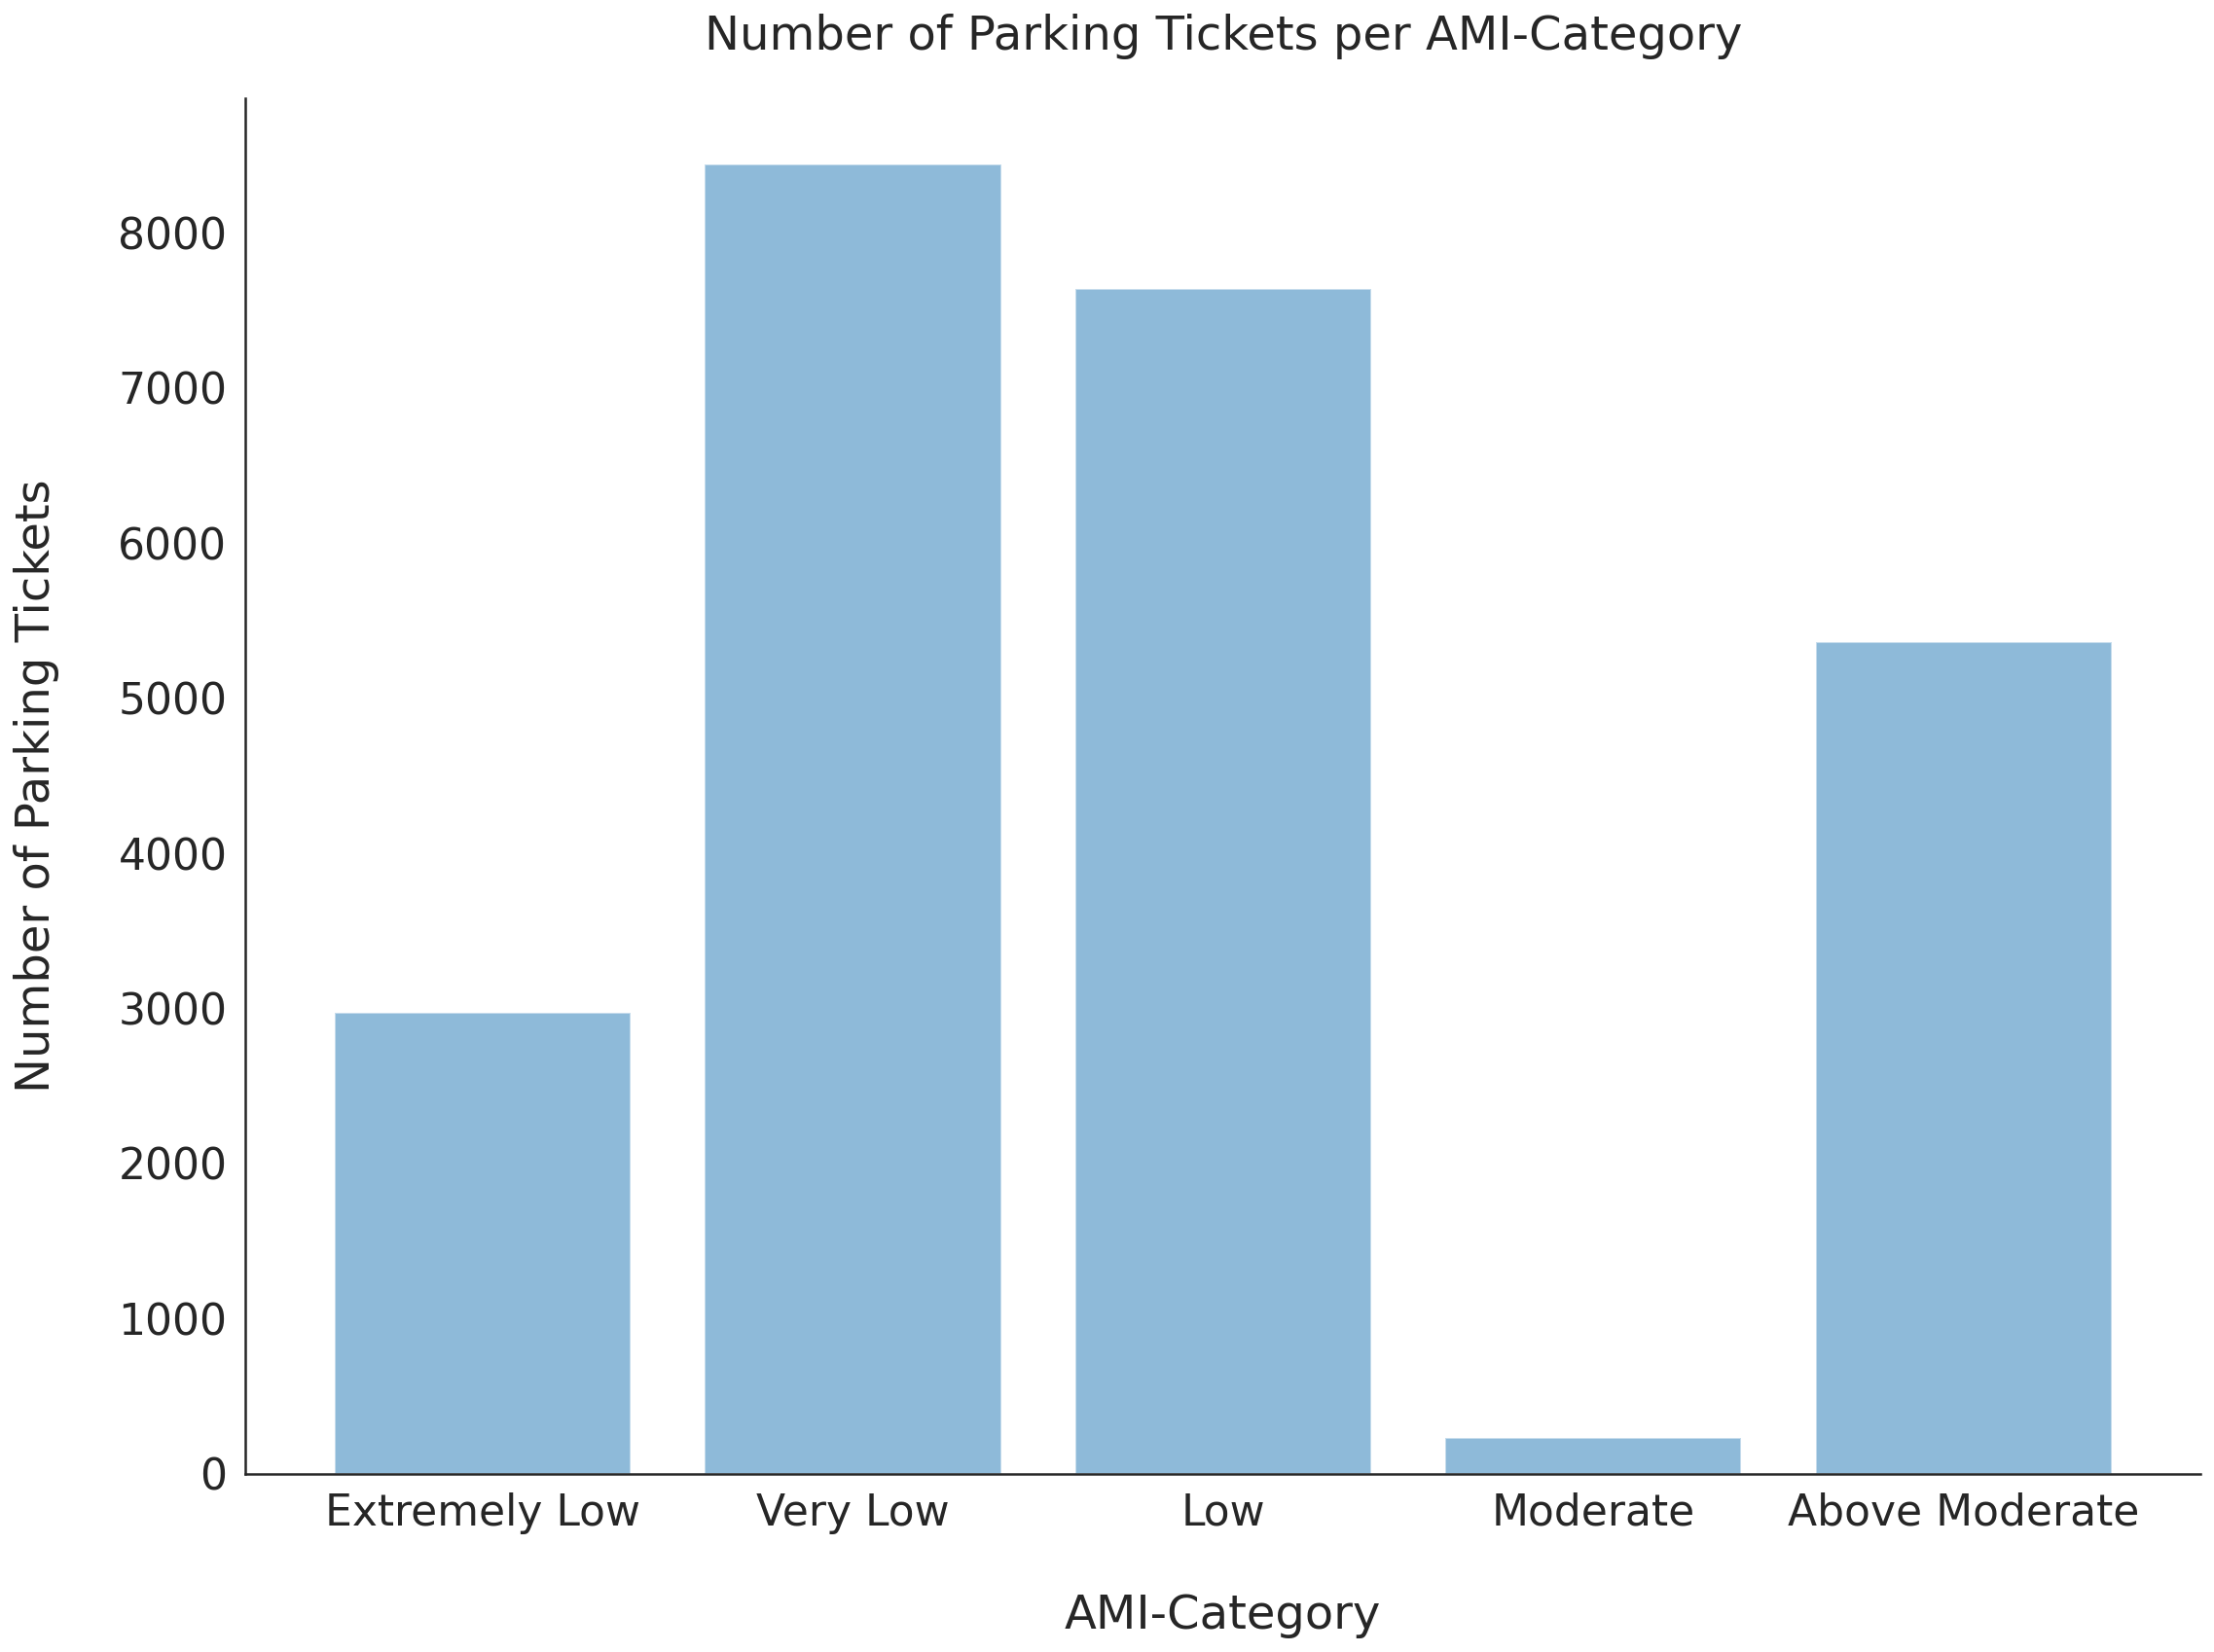

In [62]:
f1, ax = plt.subplots(figsize=(18,13))
ax.bar(income_tickets.keys(), income_tickets.values(), width=0.8, color='tab:blue', alpha=0.5)
ax.set_xlabel('AMI-Category', labelpad=30)
ax.set_ylabel('Number of Parking Tickets', labelpad=30)
ax.set_title('Number of Parking Tickets per AMI-Category', pad=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Well this is interesting! As it appears, the number of parking tickets are the highest for very low income areas, and the lowest for moderate income areas. Yet, the graph seems to outline a drastic drop in parking tickets from low income to moderate income, followed by a drastic increase in parking tickets for above moderate income. Why might this be? Could there be a bias in our data? Perhaps not much data was collected from moderate income communities. Or maybe there are less moderate income communities in LA in general (in comparison to the other income categories). We will be exploring these possibilities in our heatmap later on. For now, let's take a look at some other potential relationships between parking tickets and income levels.

The AMI dataset categorized locations under specific AMI categories. When we merged our two datasets, we classified the location of the parking tickets based on income level, meaning that different areas in LA were grouped into certain income levels. Creating a similar barchar as above for these regions may provide a more detailed perspective on the number of parking tickets for various income levels

In [63]:
df['csa'].unique()

array(['Downtown', 'Westlake', 'Mar Vista', 'Temple-Beaudry', 'Melrose',
       'North Hollywood', 'Harbor Gateway', 'Historic Filipinotown',
       'West Los Angeles', 'Hancock Park', 'Brentwood', 'Sherman Oaks',
       'Mid-city', 'Hollywood Hills', 'Canoga Park', 'Panorama City',
       'Alsace', 'Little Tokyo', 'Leimert Park', 'Eagle Rock',
       'Boyle Heights', 'Van Nuys', 'Echo Park', 'Chinatown',
       'West Adams', 'Hyde Park', 'Reseda', 'Florence-Firestone',
       'Harvard Heights', 'Koreatown', 'Carthay', 'Wilmington',
       'Westchester', 'Wholesale District', 'Bel Air',
       'Cloverdale/Cochran', 'Venice', 'Hollywood', 'Vernon Central',
       'Toluca Lake', 'Palms', 'Atwater Village', 'Westwood',
       'Century City', 'San Pedro', 'Highland Park', 'Northridge',
       'Silverlake', 'Wilshire Center', 'El Sereno', 'Lincoln Heights',
       'Vermont Knolls', 'University Park', 'East Hollywood', 'Encino',
       'Pico-Union', 'Pacoima', 'Winnetka', 'Vermont Vista',
  

In [64]:
top_10_areas = df['csa'].value_counts()[:10]
top_10_areas

Downtown              1750
Hollywood             1389
Melrose               1315
West Los Angeles       804
Wholesale District     778
Venice                 718
North Hollywood        686
Westlake               663
Sherman Oaks           661
Boyle Heights          581
Name: csa, dtype: int64

In [65]:
top_10_income_tickets = df[df['csa'].isin(top_10_areas.index.tolist())].groupby(['csa', 'ami_category'])\
['Ticket number'].count().unstack(0).fillna(0).reset_index()
top_10_income = top_10_income_tickets.transpose()
top_10_income.columns = top_10_income.iloc[0]
top_10_income = top_10_income.drop(top_10_income.index[0]).reset_index()

Text(0, 0.5, 'Region')

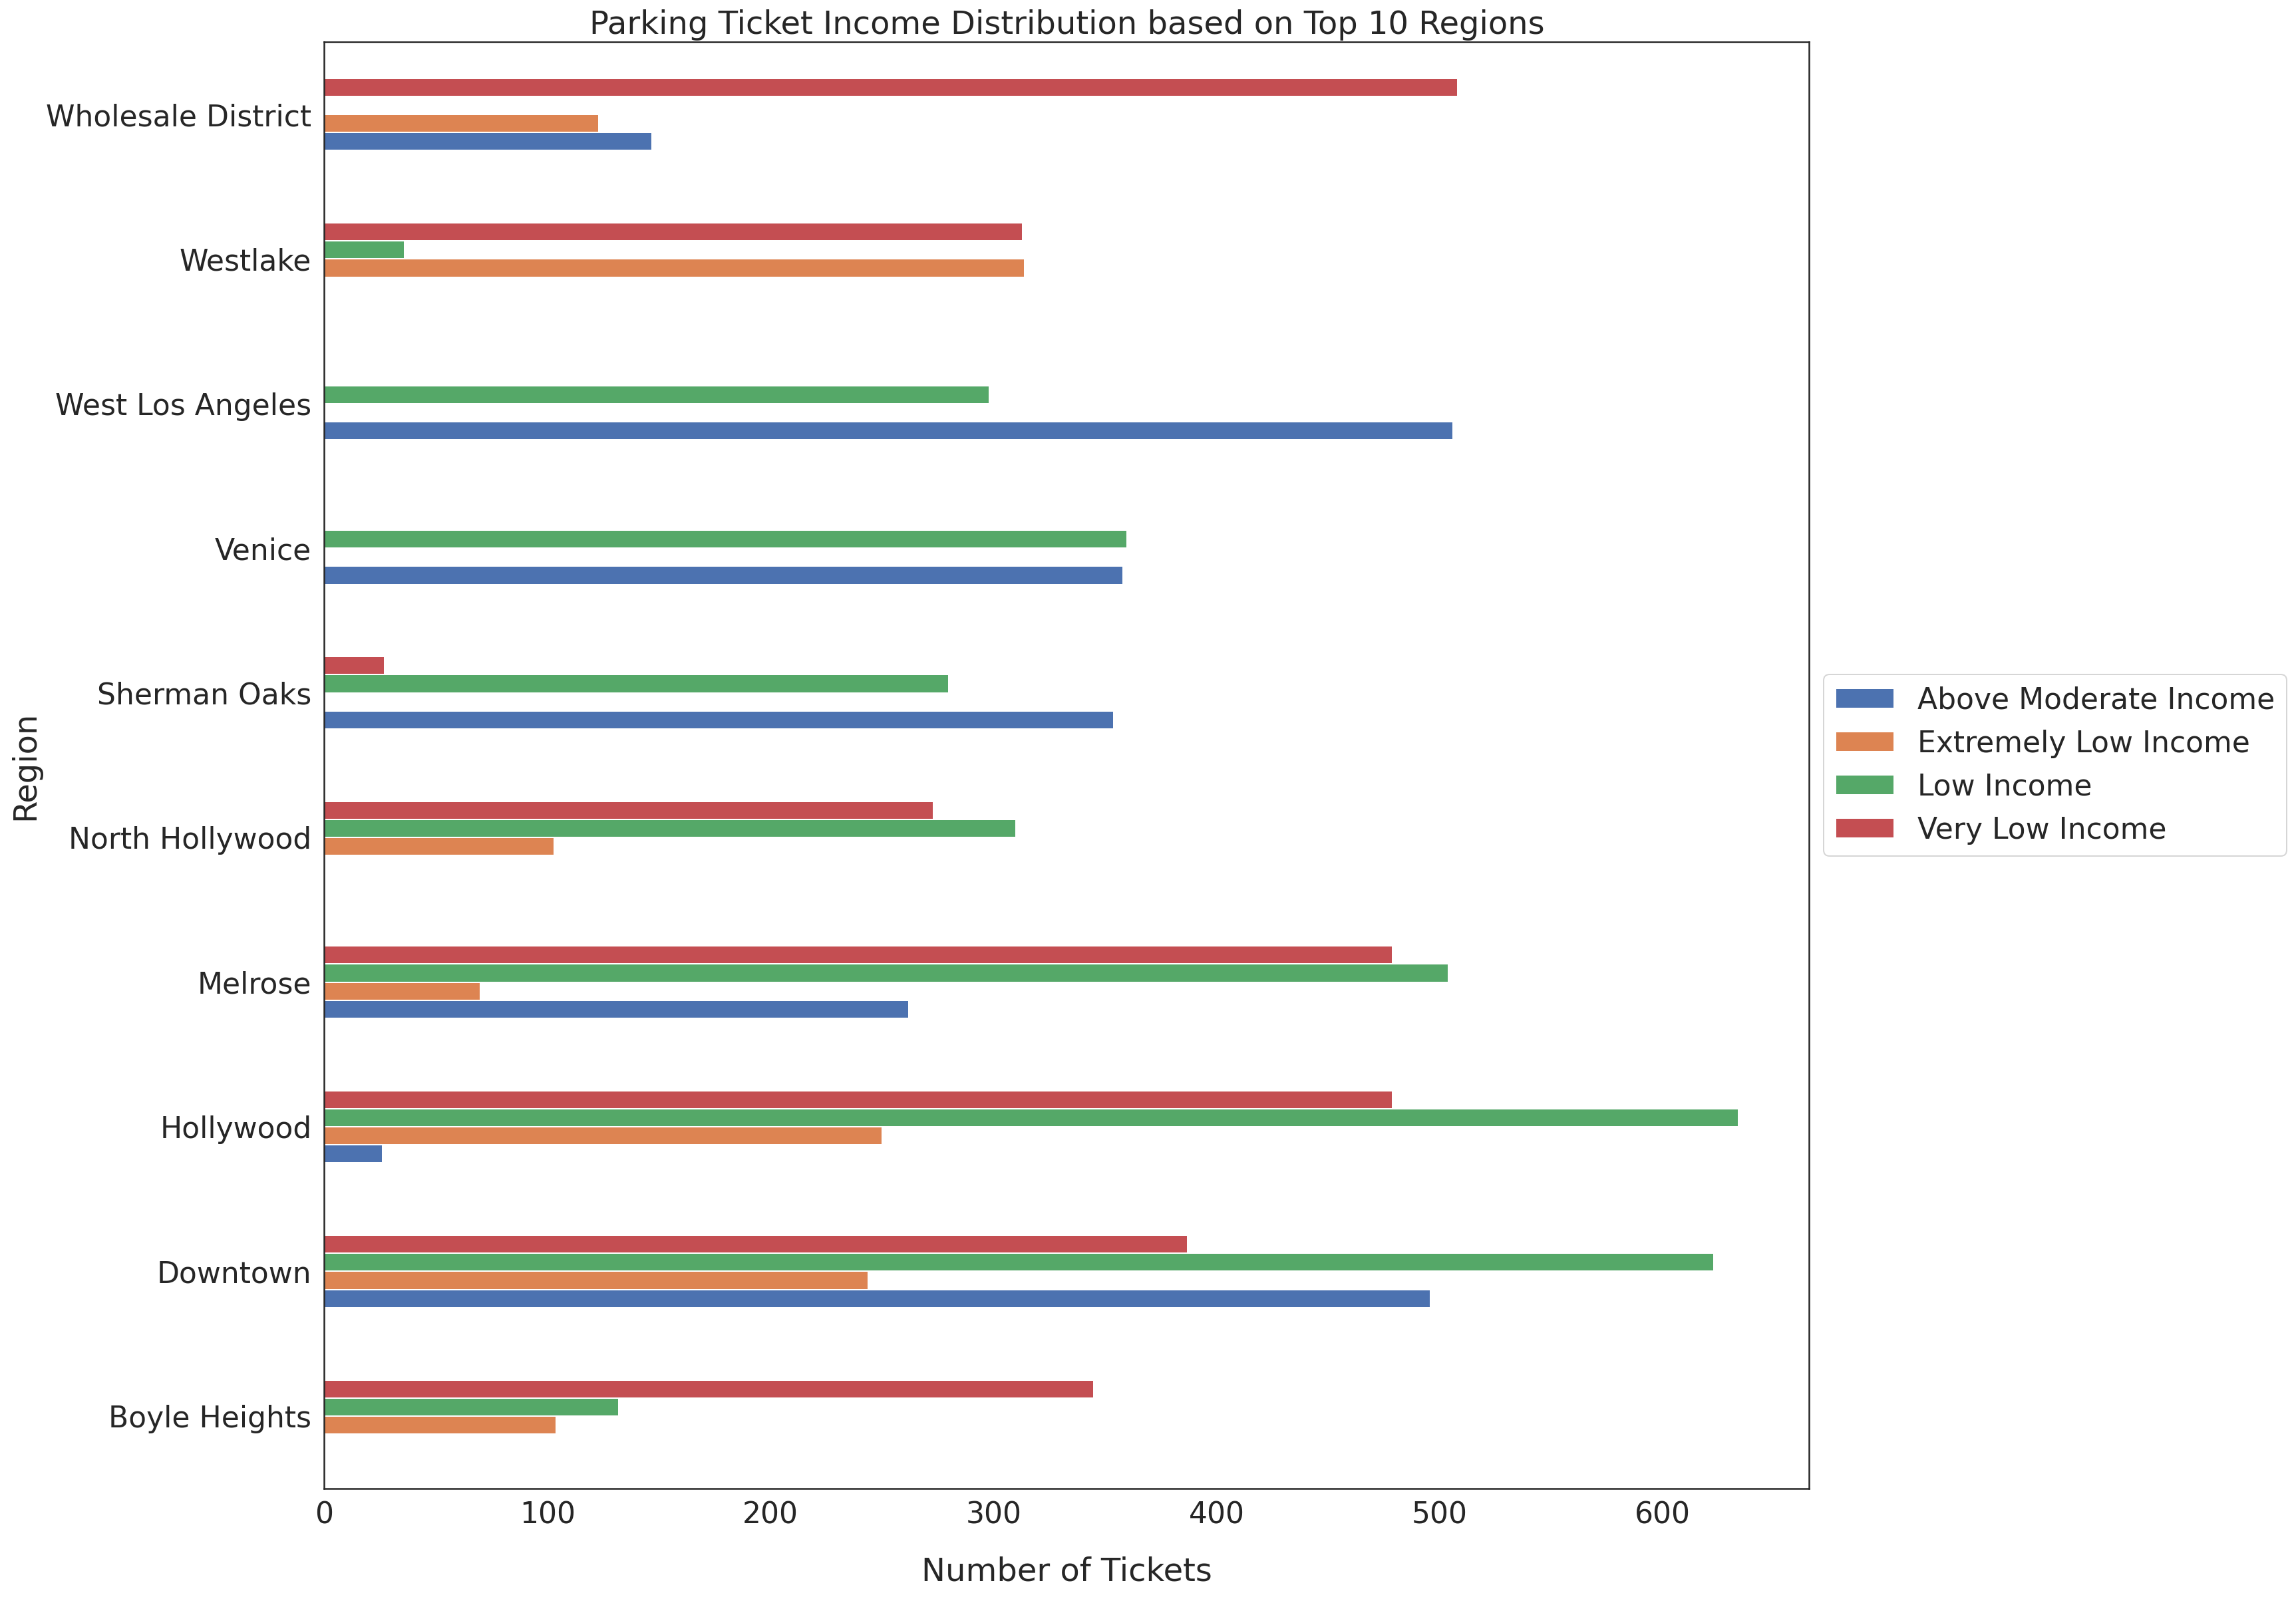

In [66]:
top_10_income.plot(x='csa',
                  kind='barh',
                  stacked=False,
                  title='Parking Ticket Income Distribution based on Top 10 Regions',
                  figsize=(20,20))
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Number of Tickets', labelpad=20)
plt.ylabel('Region')

At first, this graph may be difficult to read but we believe it is important to see any variations in parking tickets within the same area. The barchart illustrates the number of parking tickets for each ami category in the regions with the top 10 number of parking tickets. Evidentally, there seems to be a lot of variation amongst the regions, indicating that many regions in LA are diverse in terms of their economic status, even in the same region. We can also see that many of the top parking ticket quanitites come from the very low income, low income, and above moderate income areas. Additionally, the places listed in the top 10 tend to be places of high traffic and vacationing, which could be a factor playing into the number of tickets reported (people may need to park in numerous locations when travelling to LA). As such, these parking tickets may not be representative of the income levels in the area, since people from all over may be visiting these regions.

In [67]:
bottom_10_areas = df['csa'].value_counts()[-10:]
bottom_10_areas

Shadow Hills           2
Carson                 2
Willowbrook            2
Burbank                2
El Segundo             1
Palisades Highlands    1
West Hollywood         1
Inglewood              1
Lynwood                1
West Chatsworth        1
Name: csa, dtype: int64

In [68]:
bottom_10_income_tickets = df[df['csa'].isin(bottom_10_areas.index.tolist())].groupby(['csa', 'ami_category'])\
['Ticket number'].count().unstack(0).fillna(0).reset_index()
bottom_10_income = bottom_10_income_tickets.transpose()
bottom_10_income.columns = bottom_10_income.iloc[0]
bottom_10_income = bottom_10_income.drop(bottom_10_income.index[0]).reset_index()

Text(0, 0.5, 'Number of Tickets')

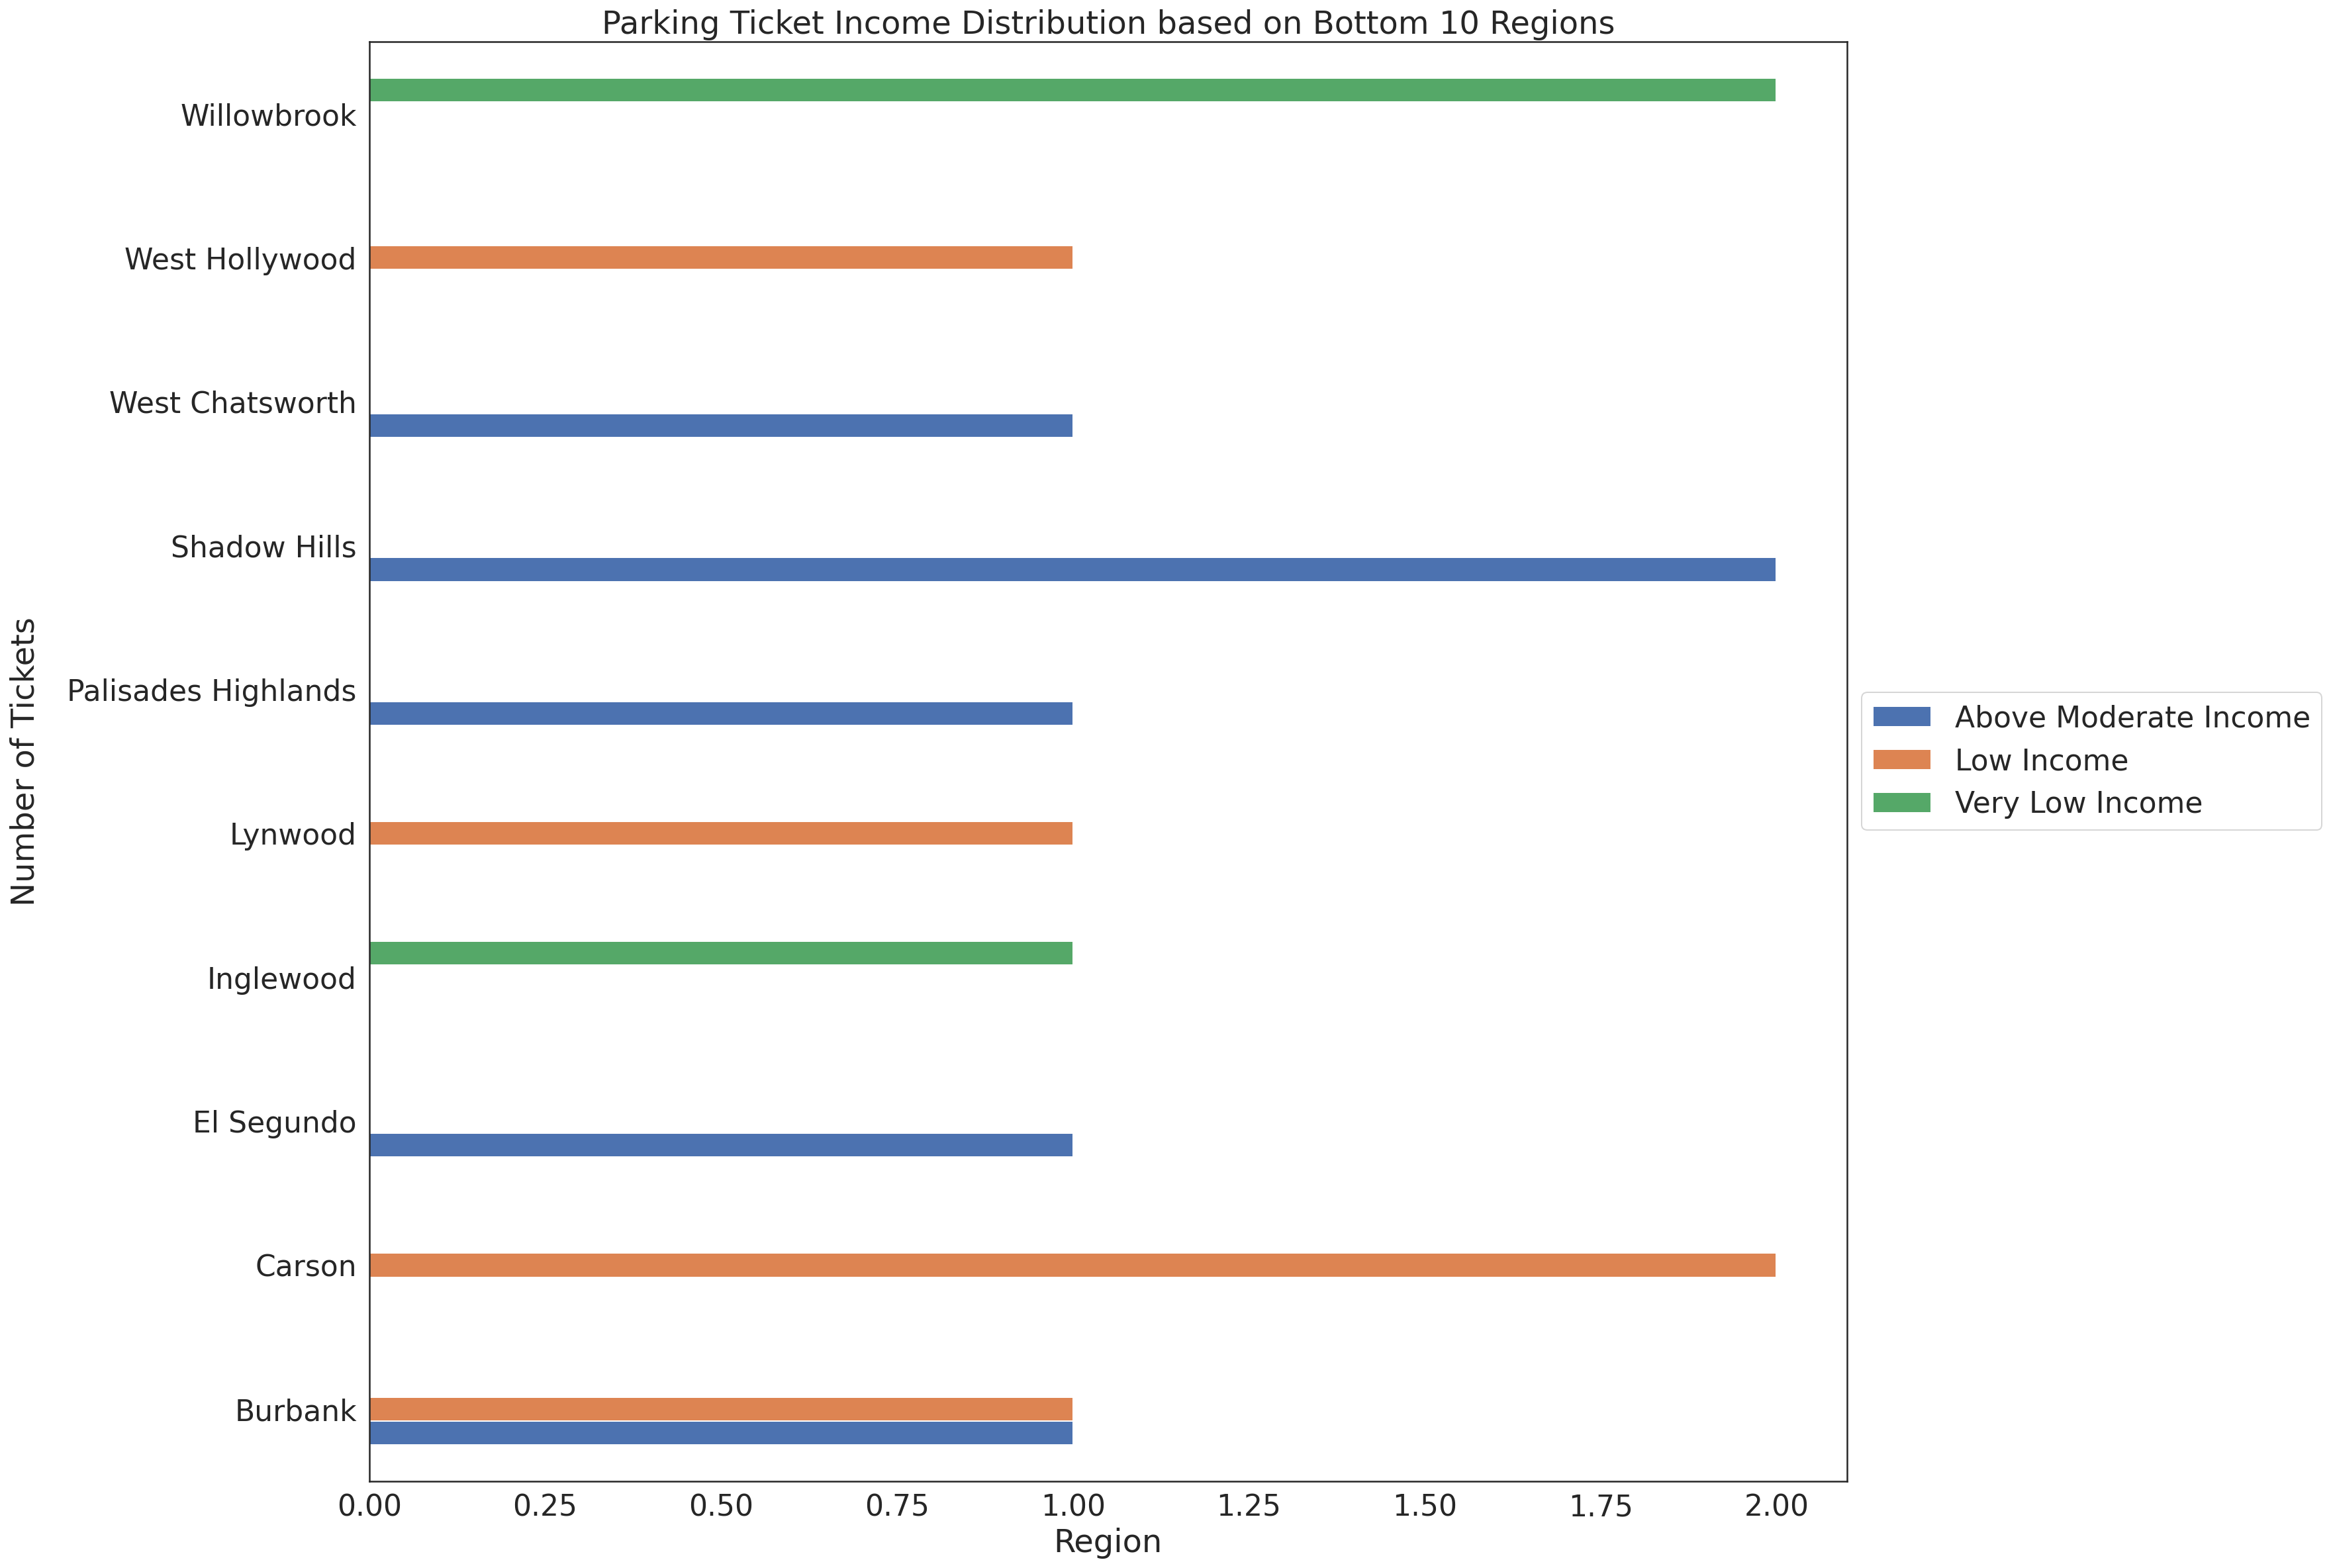

In [69]:
bottom_10_income.plot(x='csa',
                     kind='barh',
                     stacked=False,
                     title='Parking Ticket Income Distribution based on Bottom 10 Regions',
                     figsize=(20,20))
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Region')
plt.ylabel('Number of Tickets', labelpad=20)

This graph illustrates the number of parking tickets for each ami category in the regions with the bottom 10 number of parking tickets, which is why there are significantly less datapoints. The data is mostly made up of low income and above moderate income levels, with some very low income as well. However, there is no data for extremely low income. These trends could be explained by the fact that a majority of these regions are suburban or less-populated, so there are less people (and travelers) that park in the area. Something interesting to consider, though, is that in both this graph and the graph above, moderate income was not included.

In order to further look into any possible confounding variables for number of parking tickets in different economic areas, we can investigate the case of travelers parking in LA neighborhoods and cities. Since people vacationing in LA may not identify with the ami category of the area they parked in, this may blur the line between number of parking tickets and economic status. For our analysis, we will be assuming that cars with plates not from California are travelers.

In [70]:
print('Total Parking Tickets: ', df.shape[0])
print('Parking Tickets for Travelers: ', df[df['RP State Plate'] != 'CA'].shape[0])
print('Proportion of Traveler Tickets: ', df[df['RP State Plate'] != 'CA'].shape[0]/df.shape[0])

Total Parking Tickets:  24646
Parking Tickets for Travelers:  1766
Proportion of Traveler Tickets:  0.0716546295544916


Seems that only 7% of teh parking tickets appear to be from people traveling. This is promising since our main focus is to pinpoint a relationship between the number of parking tickets and economic status. Let's inspect the trends in the traveler dataframe to see how travelers may impact our overall data.

In [71]:
travelers = df[df['RP State Plate'] != 'CA']['ami_category'].value_counts()[['Extremely Low Income', \
                                                                            'Very Low Income', 'Low Income', \
                                                                            'Moderate Income', \
                                                                            'Above Moderate Income']]

traveler_tickets = {}
for i in travelers.index:
    traveler_tickets[i.replace(' Income', '')] = travelers[i]
    
traveler_tickets

{'Extremely Low': 201,
 'Very Low': 511,
 'Low': 583,
 'Moderate': 16,
 'Above Moderate': 455}

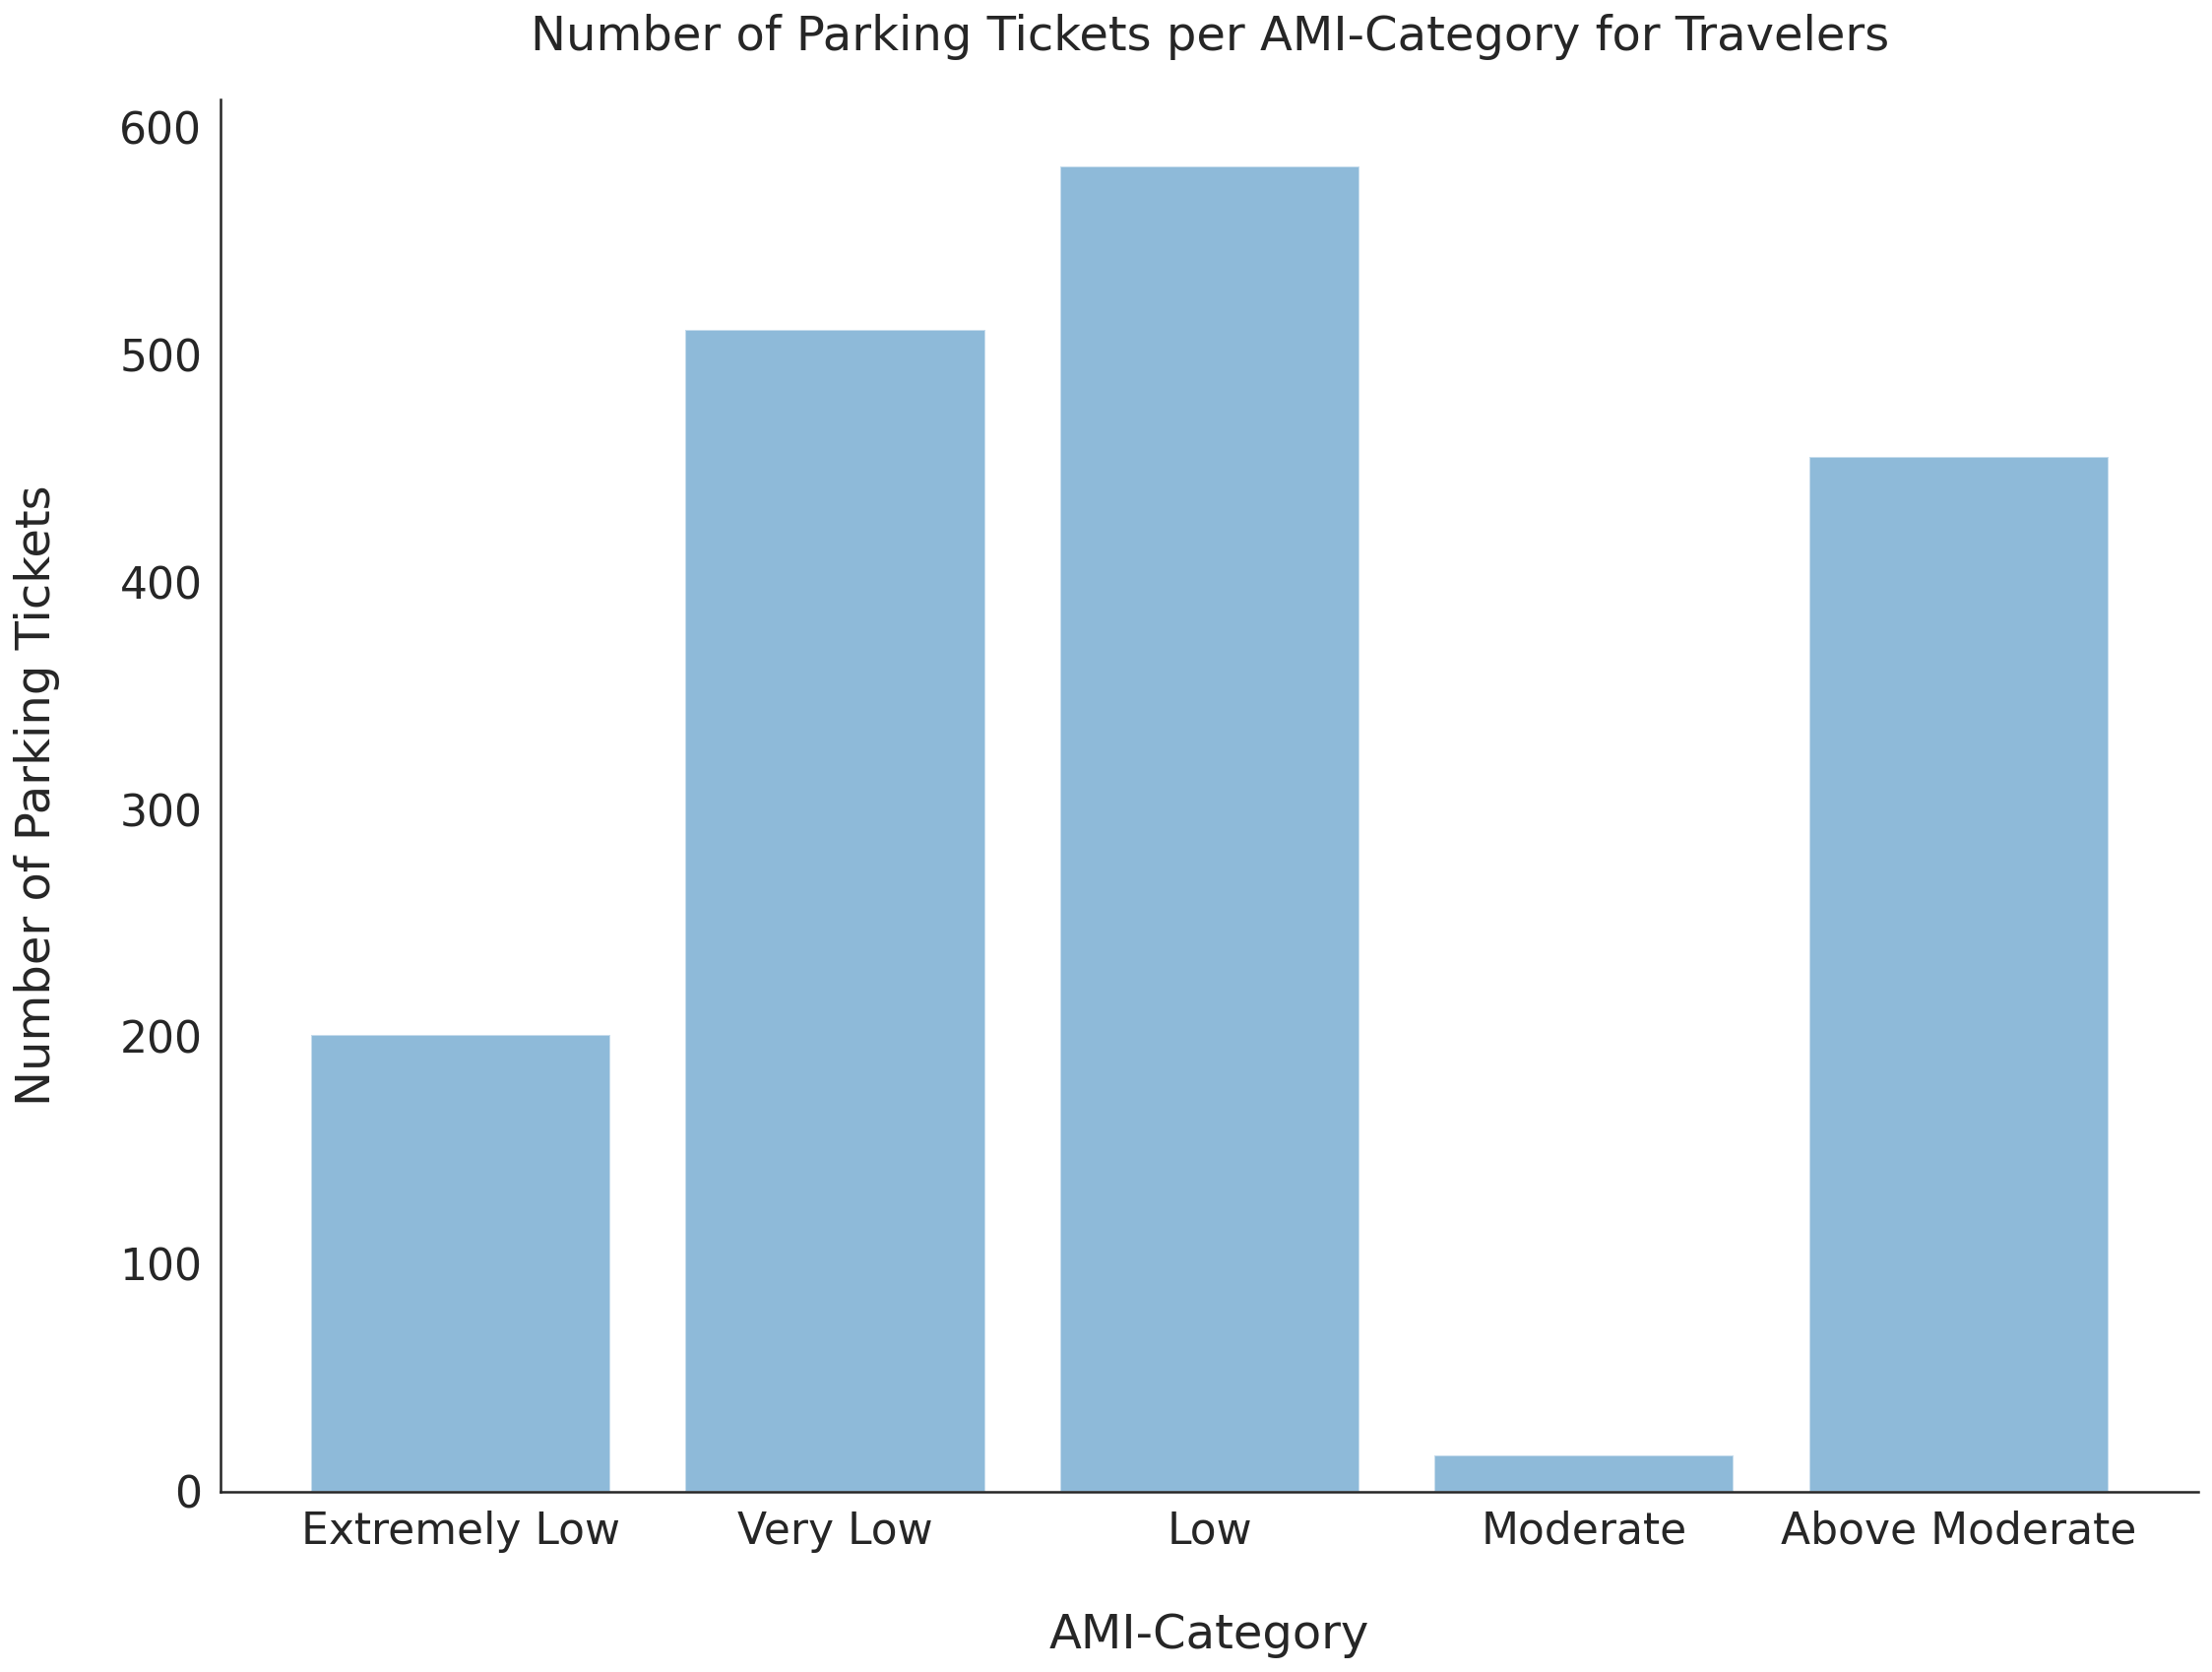

In [72]:
f3, ax = plt.subplots(figsize=(18,13))
ax.bar(traveler_tickets.keys(), traveler_tickets.values(), width=0.8, color='tab:blue', alpha=0.5)
ax.set_xlabel('AMI-Category', labelpad=30)
ax.set_ylabel('Number of Parking Tickets', labelpad=30)
ax.set_title('Number of Parking Tickets per AMI-Category for Travelers', pad=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Seems to follow a very similar trend to our barchart for all of the data. Does this graph look different for only California plates?

In [73]:
non_travelers = df[df['RP State Plate'] == 'CA']['ami_category'].value_counts()[['Extremely Low Income', \
                                                                                'Very Low Income', 'Low Income', \
                                                                                'Moderate Income', \
                                                                                'Above Moderate Income']]
non_traveler_tickets = {}
for i in non_travelers.index:
    non_traveler_tickets[i.replace(' Income', '')] = non_travelers[i]

non_traveler_tickets

{'Extremely Low': 2772,
 'Very Low': 7932,
 'Low': 7056,
 'Moderate': 214,
 'Above Moderate': 4906}

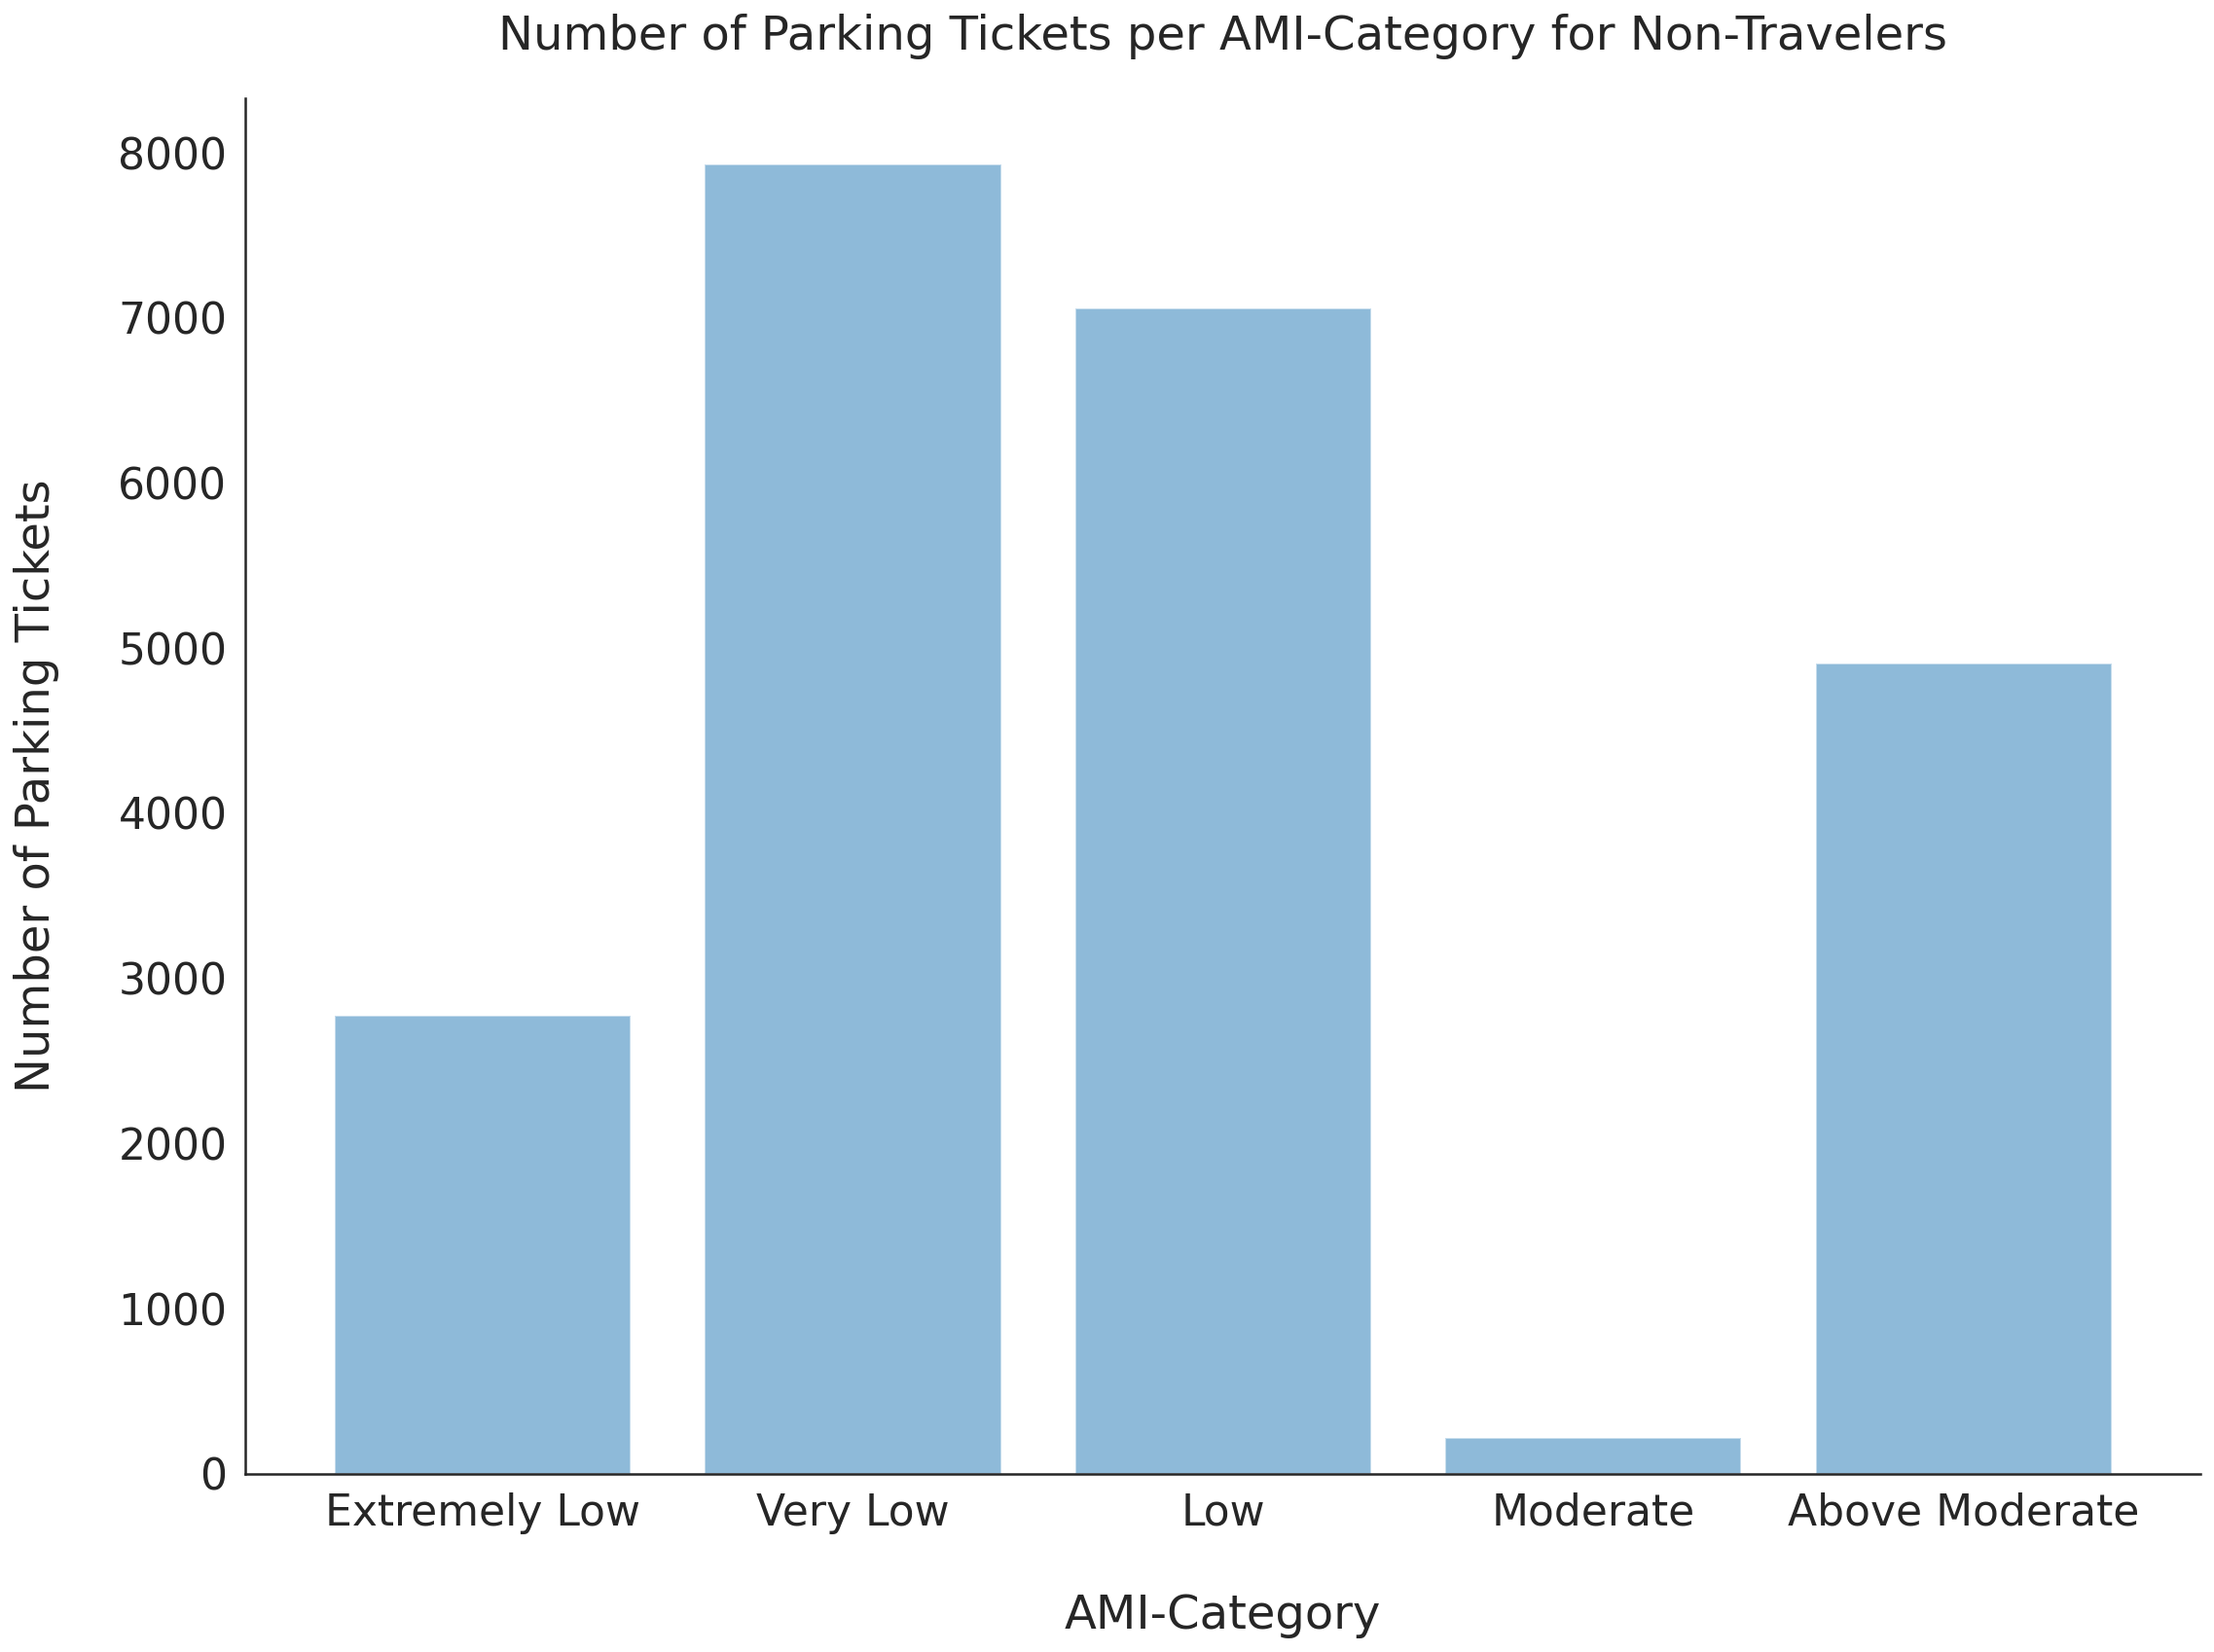

In [74]:
f4, ax = plt.subplots(figsize=(18,13))
ax.bar(non_traveler_tickets.keys(), non_traveler_tickets.values(), width=0.8, color='tab:blue', alpha=0.5)
ax.set_xlabel('AMI-Category', labelpad=30)
ax.set_ylabel('Number of Parking Tickets', labelpad=30)
ax.set_title('Number of Parking Tickets per AMI-Category for Non-Travelers', pad=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Except for some variation in the very low column, travelers and non-travelers show the same overall trend. Although we can't be for certain that the traveler 'fits' the ami-category of the place they parked, we know that cars with plates from other states don't exhibit any special treatment from the police force in our data.

In an attempt to divulge the economic status of the people parking, we can take a look at the type of car. According to our hypothesis, there should be less parking tickets for more expensive cars.

In [75]:
bottom_10_cars = df['Make'].value_counts()[-10:]
print(bottom_10_cars)

HYND    1
HYU     1
INF     1
SUBU    1
TESL    1
SAAB    1
AUBU    1
MIT     1
LROV    1
BUGA    1
Name: Make, dtype: int64


Since the count for the number of parking tickets is the same, we won't be making a barchart for this distribution, instead, our main focus is on the type of car. There is a great amount of variety in the types of cars and their economic standing. For example, the Tesla is more expensive, but then there is Saab which tends to be cheaper. Perhaps there are less parking tickets for these cars, simply because they are more rare. Let's take a look at the top 20 cars instead.

In [76]:
top_20_cars = df['Make'].value_counts()[:20].sort_values(ascending=True)

top_20_cars_tickets = {}
for i in top_20_cars.index:
    top_20_cars_tickets[i] = top_20_cars[i]

top_20_cars_tickets

{'ACUR': 272,
 'GMC': 325,
 'INFI': 328,
 'OTHR': 335,
 'SUBA': 350,
 'MAZD': 447,
 'AUDI': 520,
 'JEEP': 667,
 'LEXS': 669,
 'KIA': 711,
 'DODG': 750,
 'HYUN': 783,
 'VOLK': 813,
 'MERZ': 1077,
 'BMW': 1187,
 'CHEV': 1717,
 'NISS': 1793,
 'FORD': 1921,
 'HOND': 2933,
 'TOYT': 4192}

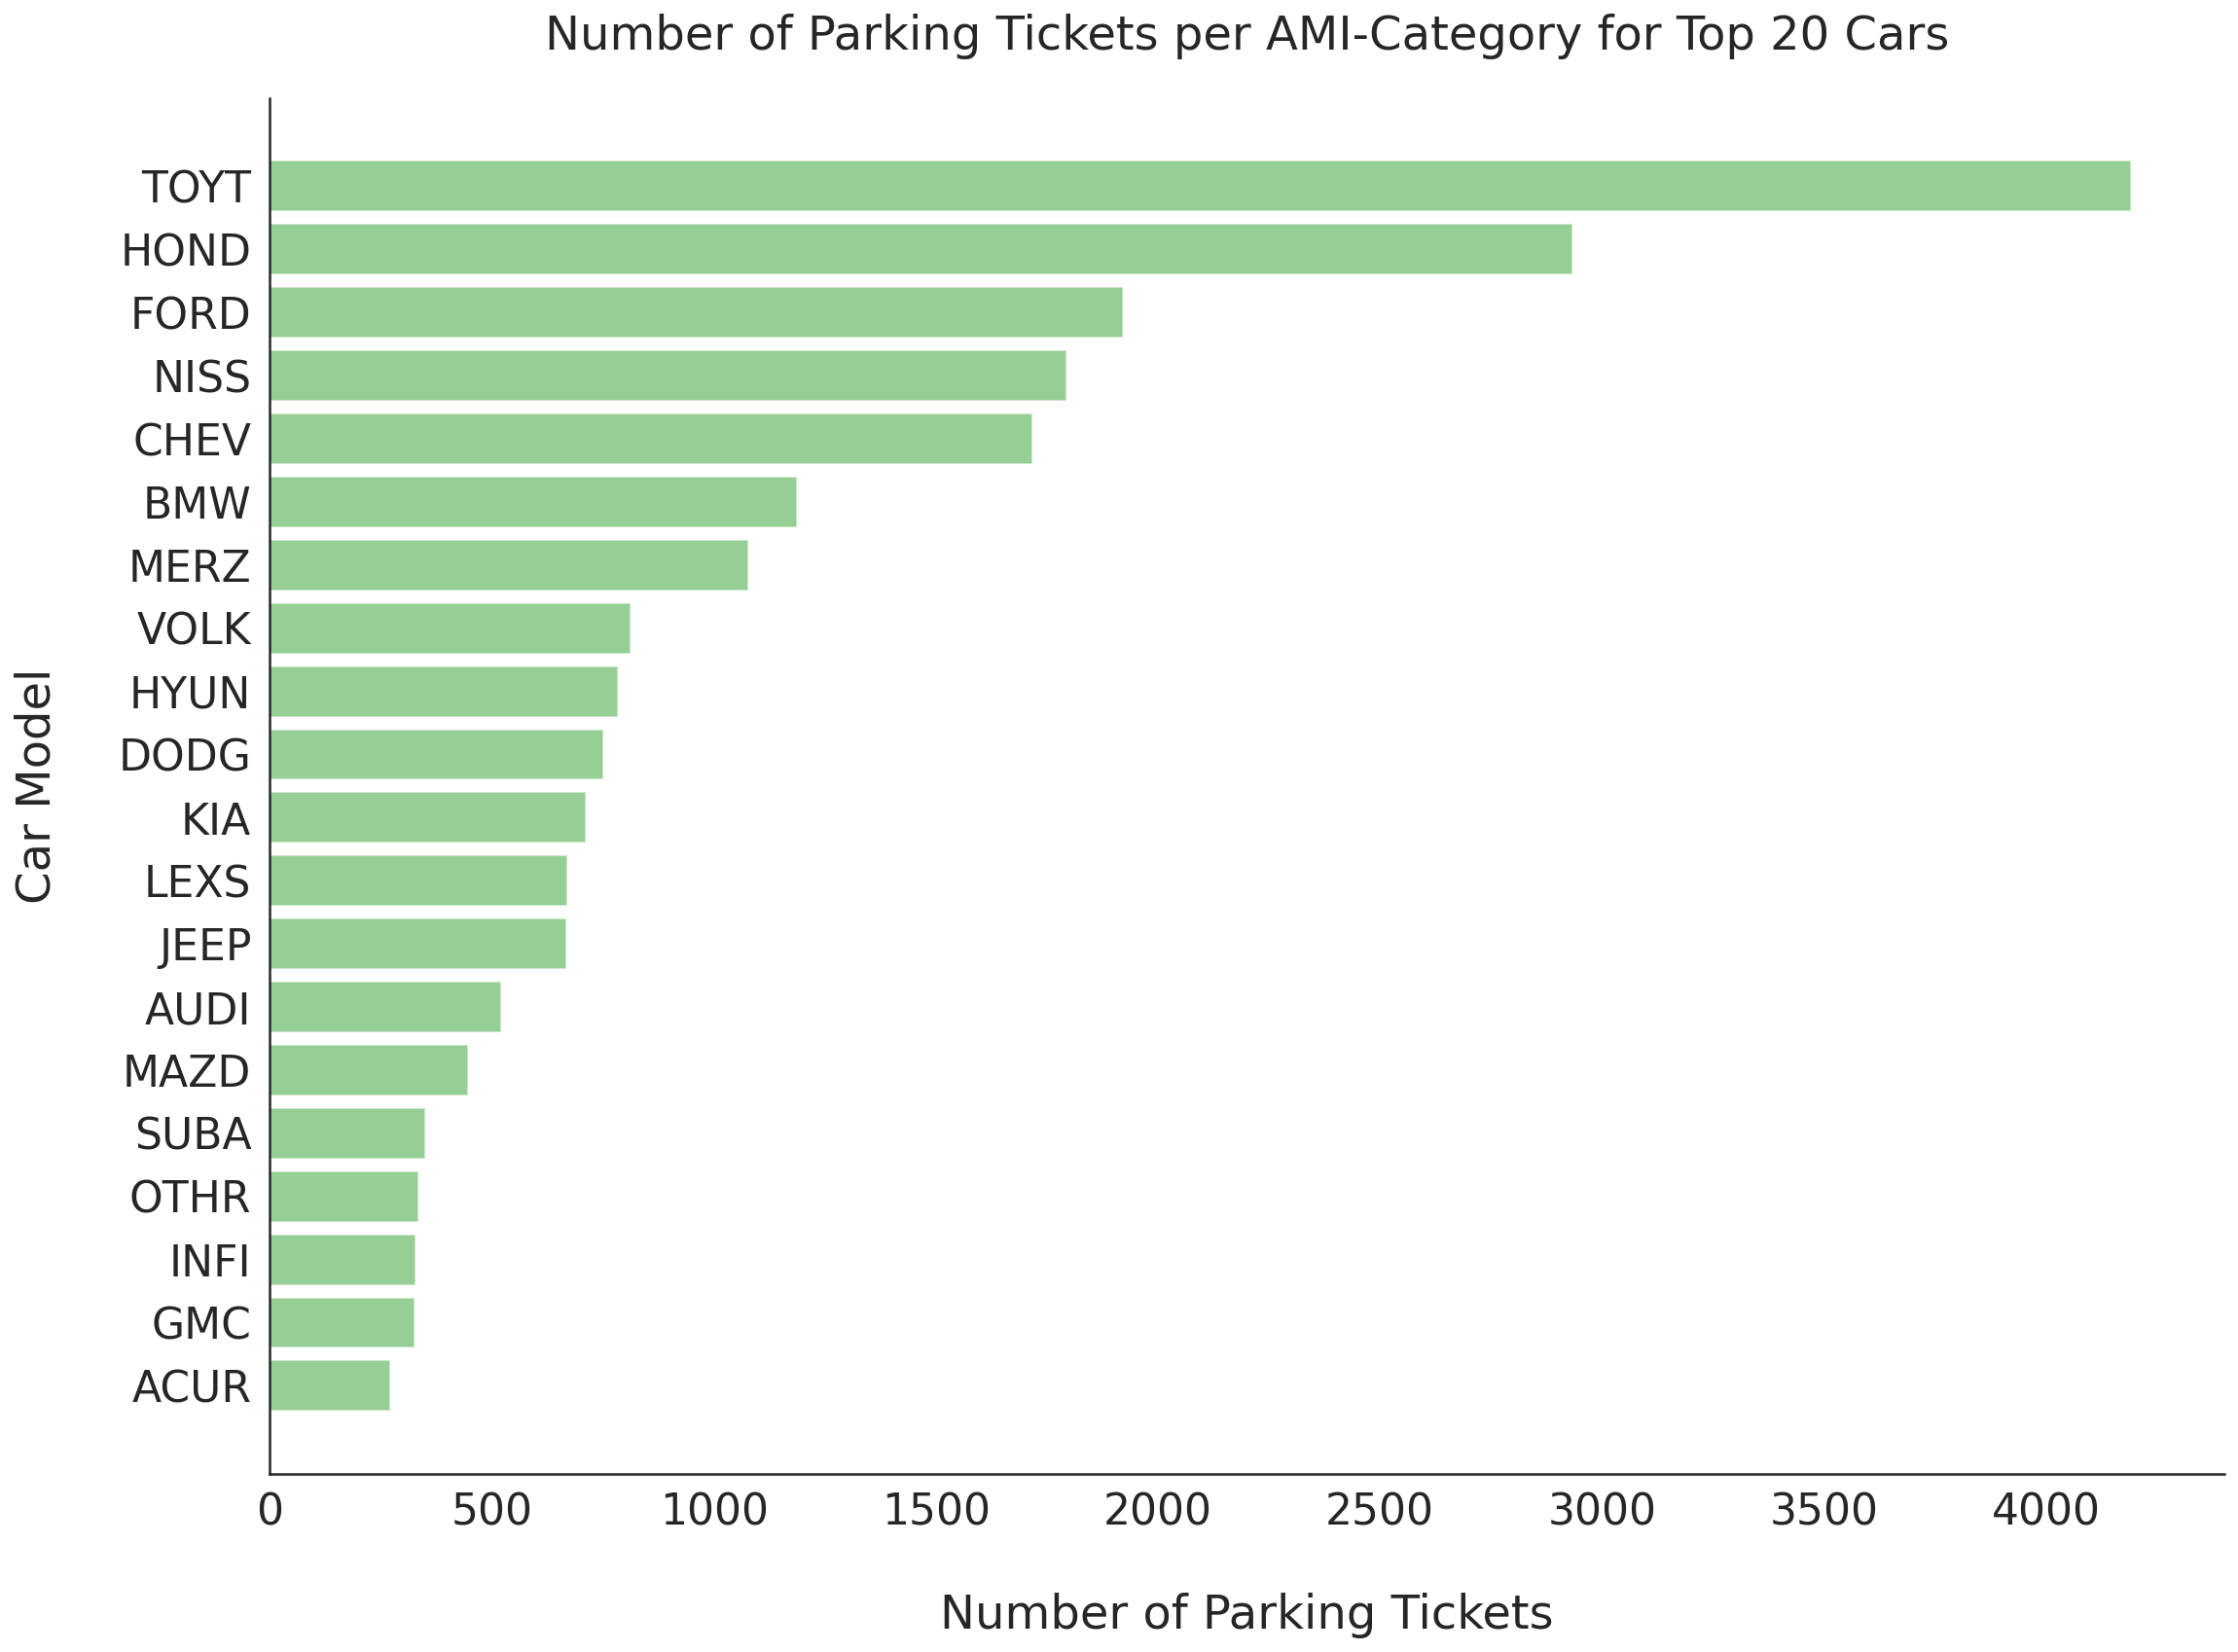

In [77]:
f5, ax = plt.subplots(1, 1, figsize=(18,13))
ax.barh(list(top_20_cars_tickets.keys()), list(top_20_cars_tickets.values()), color='tab:green', alpha=0.5)
ax.set_xlabel('Number of Parking Tickets', labelpad=30)
ax.set_ylabel('Car Model', labelpad=30)
ax.set_title('Number of Parking Tickets per AMI-Category for Top 20 Cars', pad=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

There seems to be a lot of tickets for Toyotas and Hondas. The first 5 types of cars are also affordable economical options, followed by more expensive cars (BMW and Mercedes), and then practical cars once again. While the majority of the cars are economic in the top 10, there are some more expensive cars that tend to get a lot of parking tickets as well. Additionally, more expensive car brands show up as the number of parking tickets decrease. It is important to consider, thought, that the make of the car does not necessarily describe how expensive the car is, for there are expensive Toyotas and cheaper Mazdas.

In [78]:
df2018 = df.loc[df['year'] == 2018]
df2019 = df.loc[df['year'] == 2019]
df2020 = df.loc[df['year'] == 2020]
df2021 = df.loc[df['year'] == 2021]
df2022 = df.loc[df['year'] == 2022]

In [79]:
 2018
i_t2018 = df2018['ami_category'].value_counts()[['Extremely Low Income', 'Very Low Income', \
                                        'Low Income', 'Moderate Income', 'Above Moderate Income']]
income_tickets2018 = {}
for i in i_t2018.index:
    income_tickets2018[i.replace(' Income', '')] = i_t2018[i]

# 2019 
i_t2019 = df2019['ami_category'].value_counts()[['Extremely Low Income', 'Very Low Income', \
                                        'Low Income', 'Moderate Income', 'Above Moderate Income']]
income_tickets2019 = {}
for i in i_t2019.index:
    income_tickets2019[i.replace(' Income', '')] = i_t2019[i]

#2020
i_t2020 = df2020['ami_category'].value_counts()[['Extremely Low Income', 'Very Low Income', \
                                        'Low Income', 'Moderate Income', 'Above Moderate Income']]
income_tickets2020 = {}
for i in i_t2020.index:
    income_tickets2020[i.replace(' Income', '')] = i_t2020[i]

# 2021
i_t2021 = df2021['ami_category'].value_counts()[['Extremely Low Income', 'Very Low Income', \
                                        'Low Income', 'Moderate Income', 'Above Moderate Income']]
income_tickets2021 = {}
for i in i_t2021.index:
    income_tickets2021[i.replace(' Income', '')] = i_t2021[i]

# 2022
i_t2022 = df2022['ami_category'].value_counts()[['Extremely Low Income', 'Very Low Income', \
                                        'Low Income', 'Moderate Income', 'Above Moderate Income']]
income_tickets2022 = {}
for i in i_t2022.index:
    income_tickets2022[i.replace(' Income', '')] = i_t2022[i]


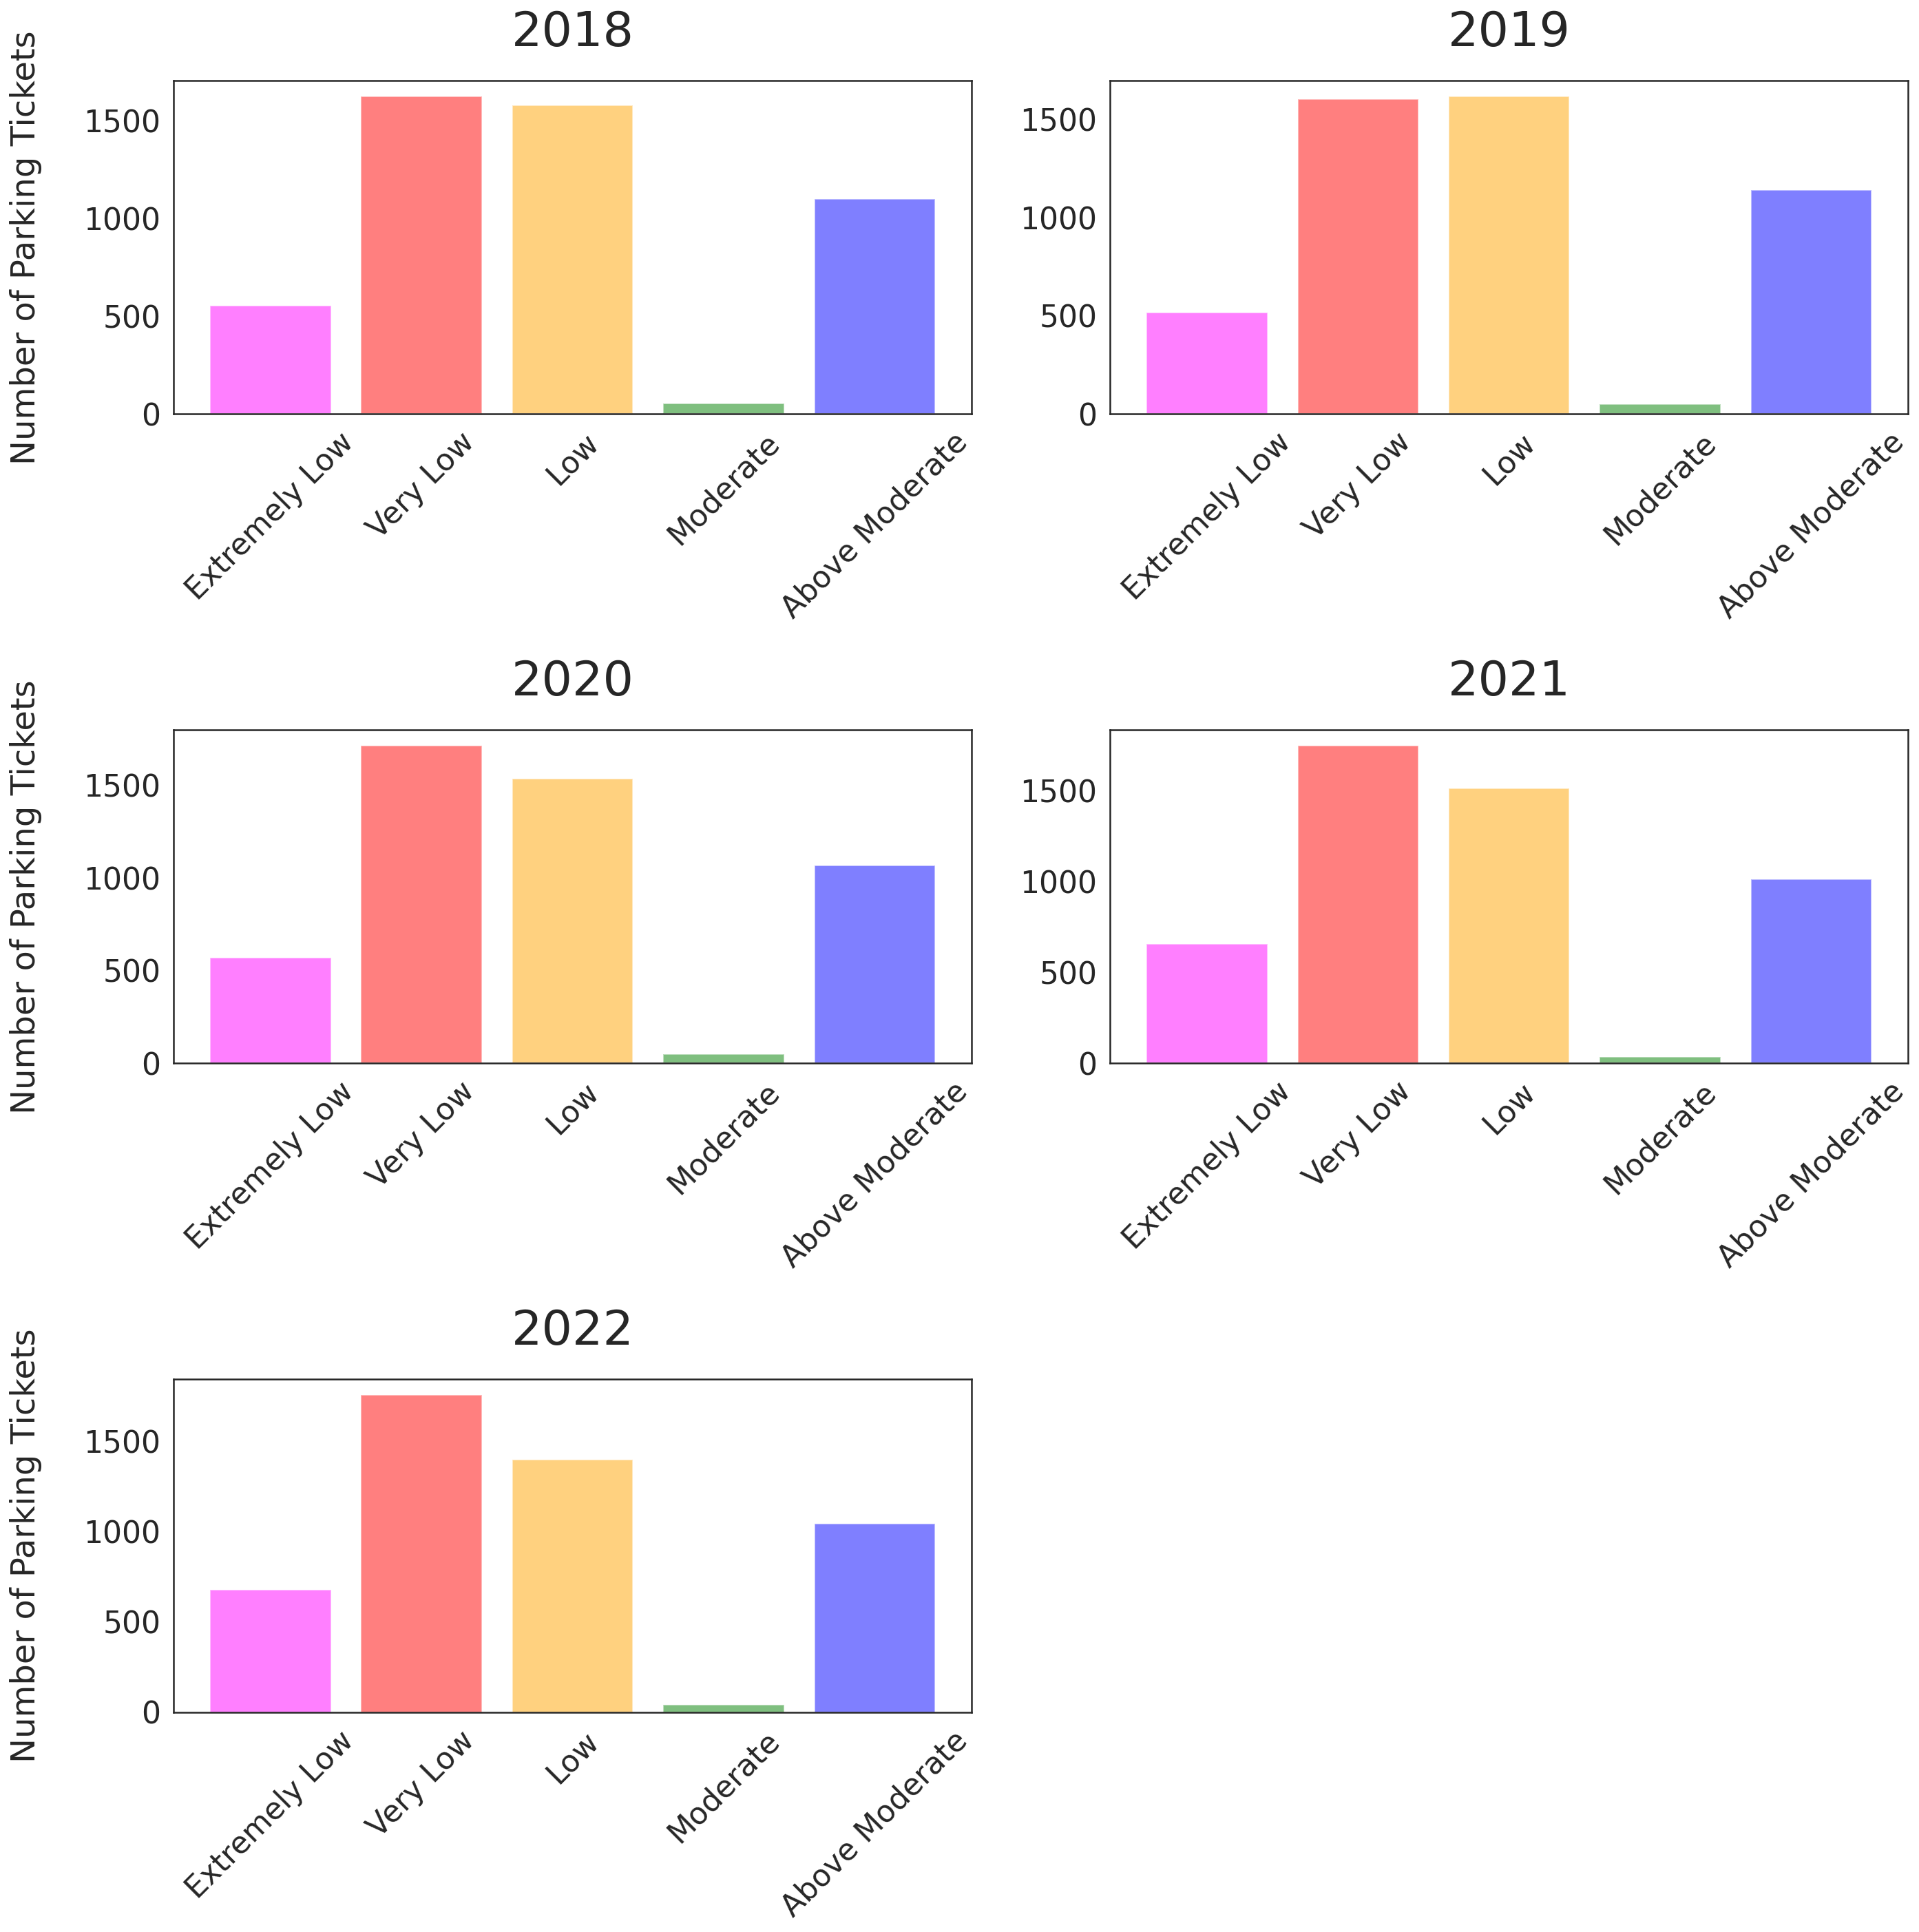

In [80]:
f3, ax = plt.subplots(3,2, figsize = (20,20))
ax[0,0].bar(income_tickets2018.keys(), income_tickets2018.values(), color=['magenta', 'red', 'orange', 'green', 'blue'], width=0.8, alpha=0.5)
ax[0,0].set_ylabel('Number of Parking Tickets', labelpad=30)
ax[0,0].tick_params(axis='x', labelrotation = 45)
ax[0,0].set_title('2018', fontsize = 35, pad=25);

ax[0,1].bar(income_tickets2019.keys(), income_tickets2019.values(), width=0.8, color=['magenta', 'red', 'orange', 'green', 'blue'], alpha=0.5)
ax[0,1].tick_params(axis='x', labelrotation = 45)
ax[0,1].set_title('2019', fontsize = 35, pad=25);

ax[1,0].bar(income_tickets2020.keys(), income_tickets2020.values(), width=0.8, color=['magenta', 'red', 'orange', 'green', 'blue'] , alpha=0.5)
ax[1,0].set_ylabel('Number of Parking Tickets', labelpad=30)
ax[1,0].tick_params(axis='x', labelrotation = 45)
ax[1,0].set_title('2020', fontsize = 35, pad=25);

ax[1,1].bar(income_tickets2021.keys(), income_tickets2021.values(), color=['magenta', 'red', 'orange', 'green', 'blue'], alpha=0.5)
ax[1,1].tick_params(axis='x', labelrotation = 45)
ax[1,1].set_title('2021', fontsize = 35, pad=25);

ax[2,0].bar(income_tickets2022.keys(), income_tickets2022.values(), color=['magenta', 'red', 'orange', 'green', 'blue'], alpha=0.5)
ax[2,0].set_ylabel('Number of Parking Tickets', labelpad=30)
ax[2,0].tick_params(axis='x', labelrotation = 45)
ax[2,0].set_title('2022', fontsize = 35, pad=25);

ax[2,1].set_visible(False)

f3.tight_layout()


This figure shows how many parking citations were issued in neighborhoods from each AMI category over the span of 5 years, since 2018. When examining each year, we can see that a consistent trend in parking citations is that the very low and low AMI category neighborhoods make up a large proportion of the citations each year. Moderate seems to be the smallest affected AMI category across all charts. As a result, by looking over a span of 5 years we can see very low and low AMI neighborhoods being the most affected by parking citations yearly.

Lastly, we have generated a heatmap in order to visualize where all the parking ticket citations are clustered in LA county.

In [81]:
sns.set(style="darkgrid")
%matplotlib inline
sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

#opening the vector map
shp_path = "geo_export_debb1d0f-c2fc-4ff4-b23a-7acd3741c263"
#reading the shape file by using reader function of the shape lib
sf = shp.Reader(shp_path)

# citation data
# stores mapping of CSA to lat and long
df1= pd.DataFrame()
df1[['Lat', 'Lon', 'csa']]=df[['Latitude', 'Longitude', 'csa']]
df1=df1.groupby('csa').nth(0)
df1


,Lat,Lon
csa,,
Adams-Normandie,34.030649,-118.304070
Alsace,34.033035,-118.360046
Angelino Heights,34.071854,-118.253644
Arleta,34.256644,-118.442410
Athens-Westmont,33.941623,-118.309015
...,...,...
Willowbrook,33.931803,-118.230866
Wilmington,33.781392,-118.280976
Wilshire Center,34.076311,-118.295558


In [82]:
# df with count by csa. index by csa and count
df2 = df[['csa','year']].groupby('csa').count()
df3=df1.join(df2, on='csa')
df3.index=df3.index.str.lower()

df3.head()

,Lat,Lon,year
csa,,,
adams-normandie,34.030649,-118.304070,28
alsace,34.033035,-118.360046,54
angelino heights,34.071854,-118.253644,18
arleta,34.256644,-118.442410,27
athens-westmont,33.941623,-118.309015,4


In [83]:
nb = shp_path+'.shp'
print(nb)
regions = gpd.read_file(nb)


regions.sample(5)
regions['city_name']=regions['city_name'].str.lower()
regions.head(3)
regions2 = regions.copy()

geo_export_debb1d0f-c2fc-4ff4-b23a-7acd3741c263.shp


In [84]:
smap = gpd.read_file(nb)

# designate coordinate system
crs = {'init':'EPSG:4326'}
# zip x and y coordinates into single feature
pointcord = [Point(xy) for xy in zip(df3['Lon'], df3['Lat'])]
# create GeoPandas dataframe
#merged.plot('year', cmap=color, linewidth=0.8, edgecolor='0.8', figsize=(40,20))
geo_df = gpd.GeoDataFrame(df3, crs=crs, geometry = pointcord)

/home/ahluong/.local/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(33.5, 34.5)

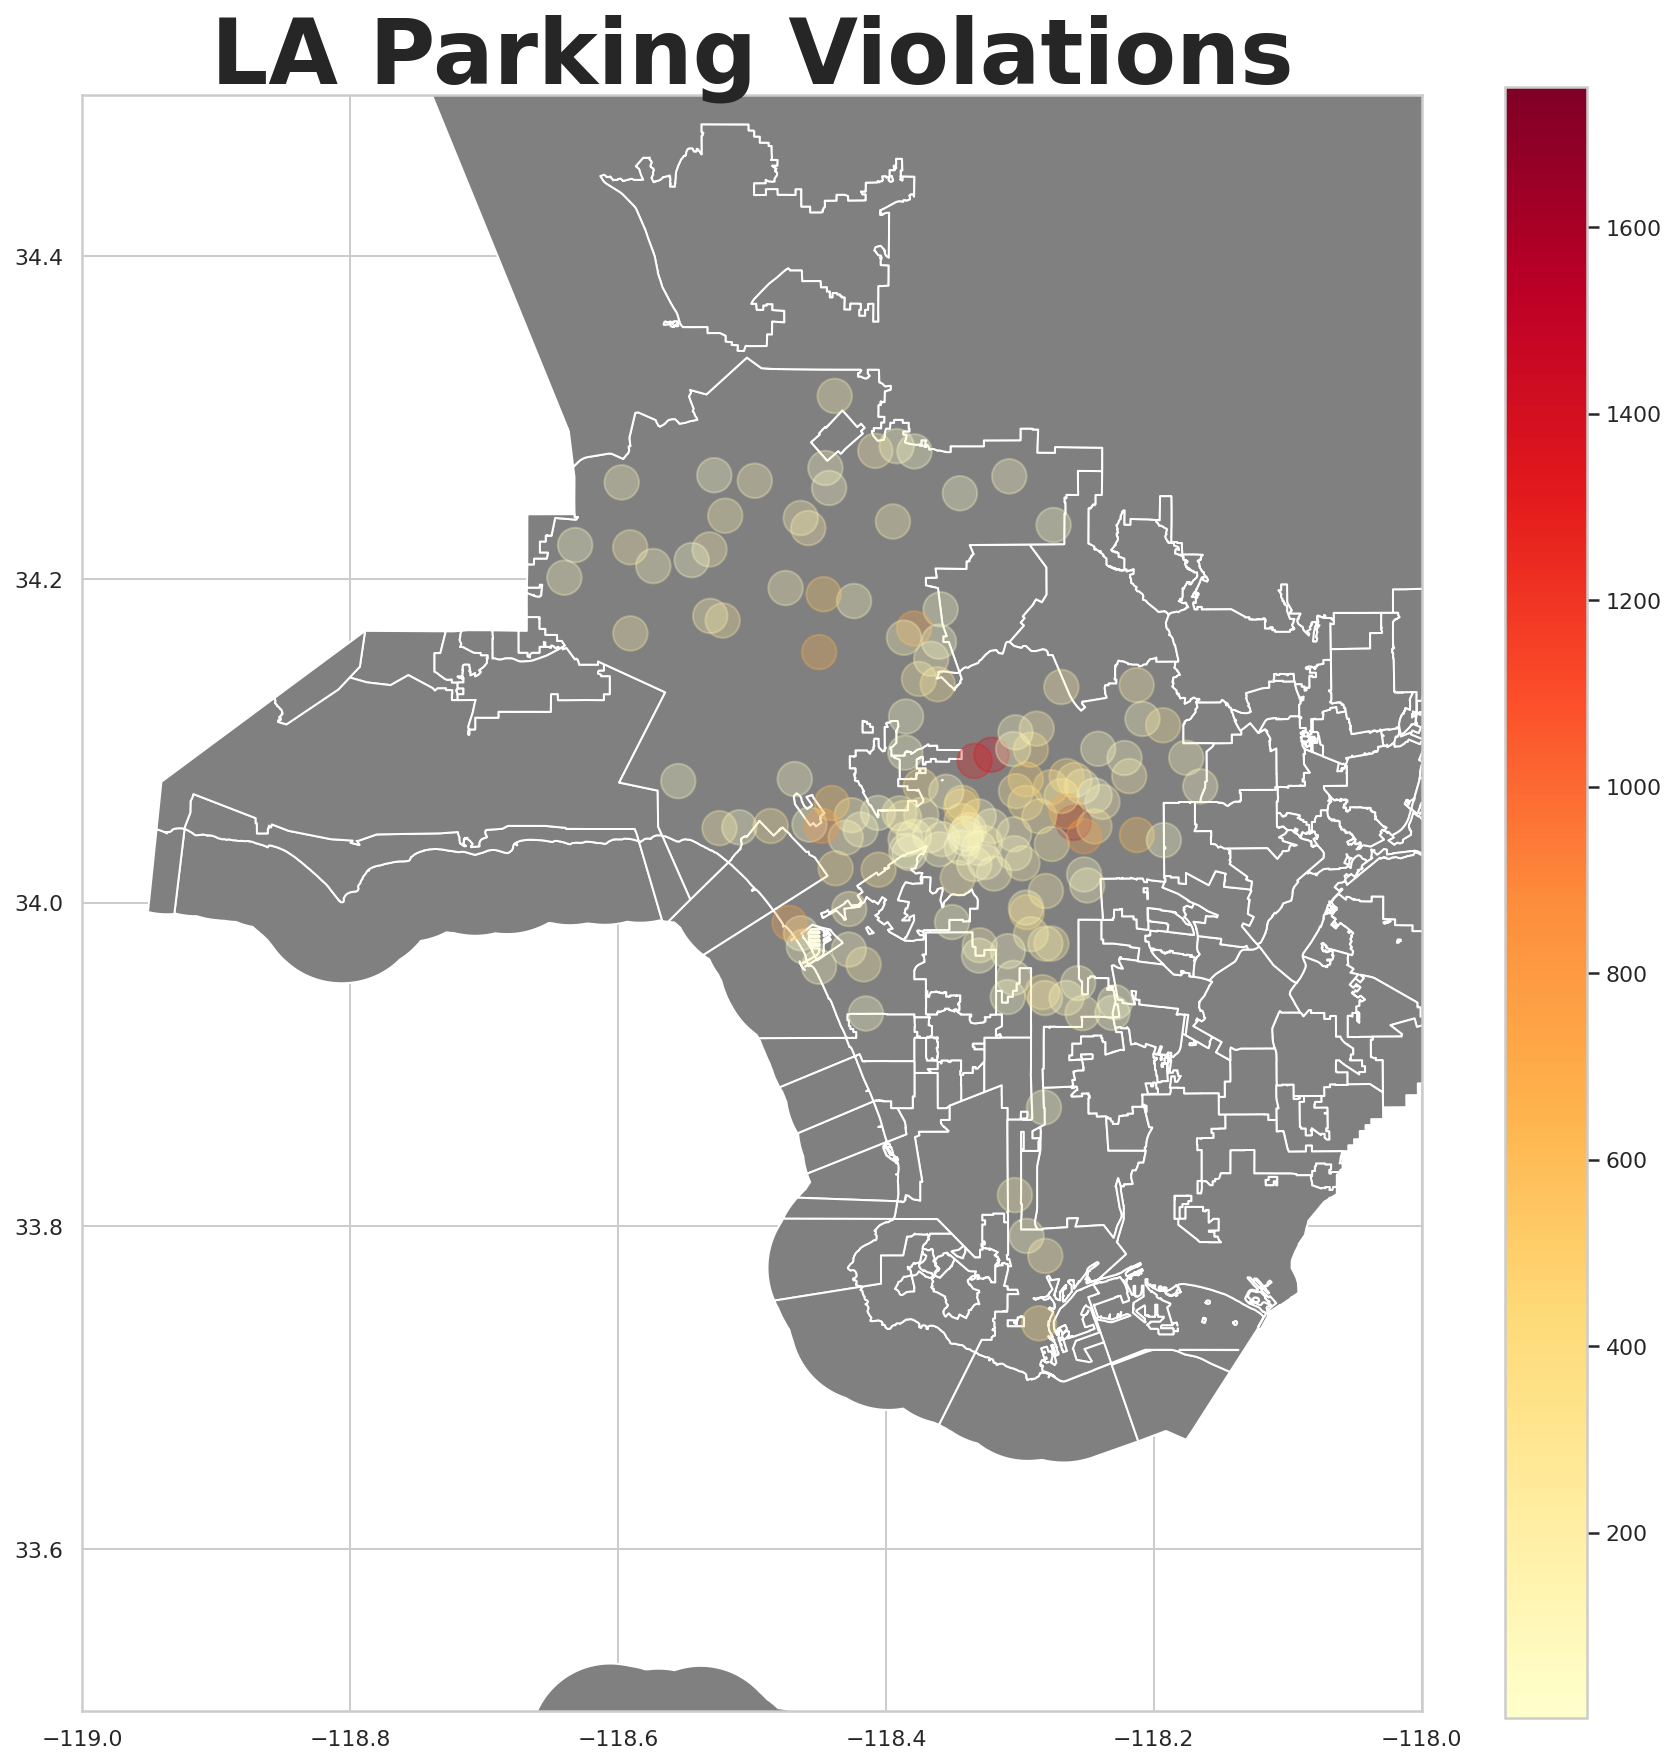

In [85]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
smap.plot(ax=ax, alpha=1,color='gray')
geo_df.plot(column='year',cmap='YlOrRd' , ax=ax, alpha=0.3, 
            legend=True,markersize=300)
# add title to graph
plt.title('LA Parking Violations', fontsize=45,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(-119,-118)
plt.ylim( 33.5,34.5)

Above is a heatmap of the parking violations in Los Angeles. On the yellow side means a lower amount of parking tickets distributed and on the red side is a higher amount of parking tickets distributed. The key is shown with the map.